# Web Scraping for Indeed.com & Predicting Salaries

In this project, we will practice two major skills: collecting data by scraping a website and then building a binary predictor with Logistic Regression.

We are going to collect salary information on data science jobs in a variety of markets. Then using the location, title and summary of the job we will attempt to predict the salary of the job. 

## 1. Scraping job listings from Indeed.com

In [4]:
import requests
import bs4
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import statsmodels.formula.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import patsy
import itertools
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score, auc
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold, GridSearchCV
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

#### Example of a single result

In [182]:
url = "https://www.indeed.co.uk/jobs?q=data+science+%C2%A325,000&l=London&start=10"

In [183]:
resp = requests.get(url)
html = resp.text

#converting html into a soup object
soup = BeautifulSoup(html, 'html.parser', from_encoding="utf-8")

Let's look at one result more closely. A single `result` looks like

```
<div class=" row result" data-jk="2480d203f7e97210" data-tn-component="organicJob" id="p_2480d203f7e97210" itemscope="" itemtype="http://schema.org/JobPosting">
<h2 class="jobtitle" id="jl_2480d203f7e97210">
<a class="turnstileLink" data-tn-element="jobTitle" onmousedown="return rclk(this,jobmap[0],1);" rel="nofollow" target="_blank" title="AVP/Quantitative Analyst">AVP/Quantitative Analyst</a>
</h2>
<span class="company" itemprop="hiringOrganization" itemtype="http://schema.org/Organization">
<span itemprop="name">
<a href="/cmp/Alliancebernstein?from=SERP&amp;campaignid=serp-linkcompanyname&amp;fromjk=2480d203f7e97210&amp;jcid=b374f2a780e04789" target="_blank">
    AllianceBernstein</a></span>
</span>
<tr>
<td class="snip">
<nobr>$117,500 - $127,500 a year</nobr>
<div>
<span class="summary" itemprop="description">
C onduct quantitative and statistical research as well as portfolio management for various investment portfolios. Collaborate with Quantitative Analysts and</span>
</div>
</div>
</td>
</tr>
</table>
</div>
```

While this has some more verbose elements removed, we can see that there is some structure to the above:
- The salary is available in a `nobr` element inside of a `td` element with `class='snip`.
- The title of a job is in a link with class set to `jobtitle` and a `data-tn-element="jobTitle`.  
- The location is set in a `span` with `class='location'`. 
- The company is set in a `span` with `class='company'`. 

### Write 4 functions to extract each item: location, company, job, and salary.

In [107]:
results = soup.find_all('div', attrs={'data-tn-component': 'organicJob'})

#### Function to get a company name

In [108]:
#Try and except clause inserted as error appears when searching for large number of results

def get_company_name(result):
    try:
        company = result.find("span", {'class':'company'}).text.strip()
    except:
        company = 'None'
    return company

In [109]:
#Checking if works:
get_company_name(results[0])

u'Novozymes'

#### Function to get a job title

In [110]:
def get_job_title(result):
    job_title = result.h2.a.get("title")
    return job_title


In [111]:
#checking if works:
get_job_title(results[0])

u'Scientist'

#### Function to get salary: (condition added in case of no salary)

In [112]:
def get_salary(result): 
    salary = result.find('nobr')
    if salary:
        salary = salary.text.strip()
        return salary
    else:
        return np.nan

In [10]:
#Checking if works:
get_salary(results[0])

u'\xa3100,000 a year'

#### Function to get location: (condition added in case of no location)

In [113]:
def get_location(result):
    location = result.find("span", class_="location").text
    if location:
        return location
    else:
        return np.nan   

In [12]:
#Checking if works:
get_location(results[0])

u'London'

#### Function to get job description:

In [114]:
def get_summary(result):
    summary = result.find("span", class_="summary").text.strip()
    return summary

In [14]:
#Checking if works:
get_summary(results[0])

u'Ideal candidates enjoy day-to-day data science problem-solving mixed with high levels of customer interaction....'

As it's hard to find enough positions with salaries in UK, I decided to look at US market. I base my city list on this post: http://www.datasciencecentral.com/profiles/blogs/the-10-best-cities-to-find-a-big-data-job. I added a couple of big cities for a good measure.

In [2]:
cities = ['Raleigh', 'Boston', 'Portland', 'San+Diego', 'Dallas', 'Denver', 'Hartford', 'Atlanta', 'St.+Louis',
          'New+York', 'Chicago', 'San+Francisco','Seattle','Los+Angeles', 'Philadelphia', 'Houston', 'Miami', 'Phoenix',
         'Philadelphia', 'Austin', 'Washington+DC', 'Sacramento', "San+Jose"]
len(cities)

23

#### Use the functions you wrote above to parse out the 4 fields - location, title, company and salary. Create a dataframe from the results with those 4 columns.

In [16]:
url_template = "http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l={}&start={}"
max_results_per_city = 1000

scrap_results = []

for city in cities:
    for start in range(0, max_results_per_city, 10):
        resp = requests.get(url_template.format(city, start))
        html = resp.text
        soup = BeautifulSoup(html, 'html.parser', from_encoding="utf-8")      
        results = soup.find_all('div', attrs={'data-tn-component': 'organicJob'})
        
        for res in results:
            company = get_company_name(res)
            location = get_location(res)
            search_city = city
            job_title = get_job_title(res)
            salary = get_salary(res)
            summary = get_summary(res)
            scrap_results.append([company, location, search_city, job_title, salary, summary])

Creating dataframe from scrap_results:

In [72]:
jobs = pd.DataFrame(scrap_results, columns=["Company", "Location", "Search_City", "Job_Title", "Salary", "Summary"])
len(jobs)

10222

In [73]:
#Checking how many not null salaries there are:
len(jobs[jobs.Salary.notnull()])

534

In [74]:
#Checking if I got any proper salaries:
jobs.Salary.value_counts().head()

$160,000 a year               10
$150,000 a year               10
$120,000 a year               10
$150,000 - $200,000 a year     8
$70,286 - $88,213 a year       7
Name: Salary, dtype: int64

Lastly, we need to clean up salary data. 

1. Only a small number of the scraped results have salary information - only these will be used for modeling.
1. Some of the salaries are not yearly but hourly or weekly, these will not be useful to us for now
1. Some of the entries may be duplicated
1. The salaries are given as text and usually with ranges.

#### Find the entries with annual salary entries, by filtering the entries without salaries or salaries that are not yearly (filter those that refer to hour or week). Also, remove duplicate entries

In [75]:
#Dropping the rows with no salary:
jobs = jobs.dropna()

#We should get 534 rows:
len(jobs)

534

In [76]:
#Dropping the rows with salary that is not annual:
mask = jobs.Salary.str.contains("year")
jobs = jobs[mask]
len(jobs)

367

In [77]:
#Removing potential duplicates:
jobs = jobs.drop_duplicates(keep = 'first')
len(jobs)

306

In [78]:
#Reindexing:
jobs = jobs.reset_index(drop=True)
jobs.head()

,Company,Location,Search_City,Job_Title,Salary,Summary
0,University of North Carolina,"Chapel Hill, NC 27517",Raleigh,Research Specialist,"$39,469 - $48,240 a year",Prepare posters and other materials for presen...
1,State of North Carolina,"Wake County, NC",Raleigh,Medicaid Statistician,"$34,997 - $82,238 a year","This is a technical position, involving the an..."
2,North Carolina Office of State Human Resources,"Wake County, NC",Raleigh,Medicaid Statistician,"$34,997 - $82,238 a year","This is a technical position, involving the an..."
3,North Carolina Office of State Human Resources,"Wake County, NC",Raleigh,Health Services Statistician,"$34,997 - $82,238 a year","This is a technical position, involving the an..."
4,State of North Carolina,"Wake County, NC",Raleigh,Health Services Statistician,"$34,997 - $82,238 a year","This is a technical position, involving the an..."


In [126]:
#Cleaning up the Search City (To remove '+' from two-word names):

jobs["Search_City"] = jobs["Search_City"].astype('str')

def remove_plus(string):
    if '+' in string:
        string = string.replace("+", " ")
    return string

In [80]:
jobs["Search_City"] = jobs["Search_City"].apply(remove_plus)

#### Write a function that takes a salary string and converts it to a number, averaging a salary range if necessary

In [81]:
# Setting Salary column type as string
jobs["Salary"]=jobs["Salary"].astype('str')

#Extracting numbers from the string into a new column
jobs["Salary_extracted"] =  jobs["Salary"].map(lambda x: "".join([d for d in x if d in '1234567890-.']))

In [82]:
jobs.head(2)

,Company,Location,Search_City,Job_Title,Salary,Summary,Salary_extracted
0,University of North Carolina,"Chapel Hill, NC 27517",Raleigh,Research Specialist,"$39,469 - $48,240 a year",Prepare posters and other materials for presen...,39469-48240
1,State of North Carolina,"Wake County, NC",Raleigh,Medicaid Statistician,"$34,997 - $82,238 a year","This is a technical position, involving the an...",34997-82238


In [130]:
#Calculating average salary for those that are ranges 
def avg_salary(salary):
    if '-' in salary:
        salary_list = salary.split('-')
        salary_list = [float(x) for x in salary_list] #changing strings into floats
        mean_salary=np.mean(salary_list)
        return mean_salary
    else:
        return float(salary)

In [84]:
#Run the function:
jobs["Avg_salary"] = jobs["Salary_extracted"].apply(avg_salary)

In [85]:
jobs.head(2)

,Company,Location,Search_City,Job_Title,Salary,Summary,Salary_extracted,Avg_salary
0,University of North Carolina,"Chapel Hill, NC 27517",Raleigh,Research Specialist,"$39,469 - $48,240 a year",Prepare posters and other materials for presen...,39469-48240,43854.5
1,State of North Carolina,"Wake County, NC",Raleigh,Medicaid Statistician,"$34,997 - $82,238 a year","This is a technical position, involving the an...",34997-82238,58617.5


In [89]:
# Dropping uneccessary columns:
jobs.drop(['Salary', 'Salary_extracted'], axis=1, inplace=True)

In [90]:
jobs.head(2)

,Company,Location,Search_City,Job_Title,Summary,Avg_salary
0,University of North Carolina,"Chapel Hill, NC 27517",Raleigh,Research Specialist,Prepare posters and other materials for presen...,43854.5
1,State of North Carolina,"Wake County, NC",Raleigh,Medicaid Statistician,"This is a technical position, involving the an...",58617.5


### Save your results as a CSV

In [91]:
jobs.to_csv('jobs_cleaned.csv', encoding='utf-8', index=False)
#df.to_csv('Job_Data.csv',encoding='utf-8')

## 2. Predicting salaries using Logistic Regression

#### Load in the the data of scraped salaries

In [32]:
jobs = pd.read_csv('jobs_cleaned.csv', encoding='utf-8')
jobs.head(2)

,Company,Location,Search_City,Job_Title,Summary,Avg_salary
0,University of North Carolina,"Chapel Hill, NC 27517",Raleigh,Research Specialist,Prepare posters and other materials for presen...,43854.5
1,State of North Carolina,"Wake County, NC",Raleigh,Medicaid Statistician,"This is a technical position, involving the an...",58617.5


#### We want to predict a binary variable - whether the salary was low or high. Compute the median salary and create a new binary variable that is true when the salary is high (above the median)

We could also perform Linear Regression (or any regression) to predict the salary value here. Instead, we are going to convert this into a _binary_ classification problem, by predicting two classes, HIGH vs LOW salary.

While performing regression may be better, performing classification may help remove some of the noise of the extreme salaries. We don't have to choice the `median` as the splitting point - we could also split on the 75th percentile or any other reasonable breaking point.

In fact, the ideal scenario may be to predict many levels of salaries, 

#### Calculating median salary:

In [33]:

median_salary = np.median(jobs.Avg_salary)
median_salary

95000.0

#### Checking salary statistics:

In [34]:
jobs.Avg_salary.describe()

count       306.000000
mean     104072.810458
std       47233.119731
min       24000.000000
25%       65233.500000
50%       95000.000000
75%      140000.000000
max      250000.000000
Name: Avg_salary, dtype: float64

#### Plotting salary distribution with median:

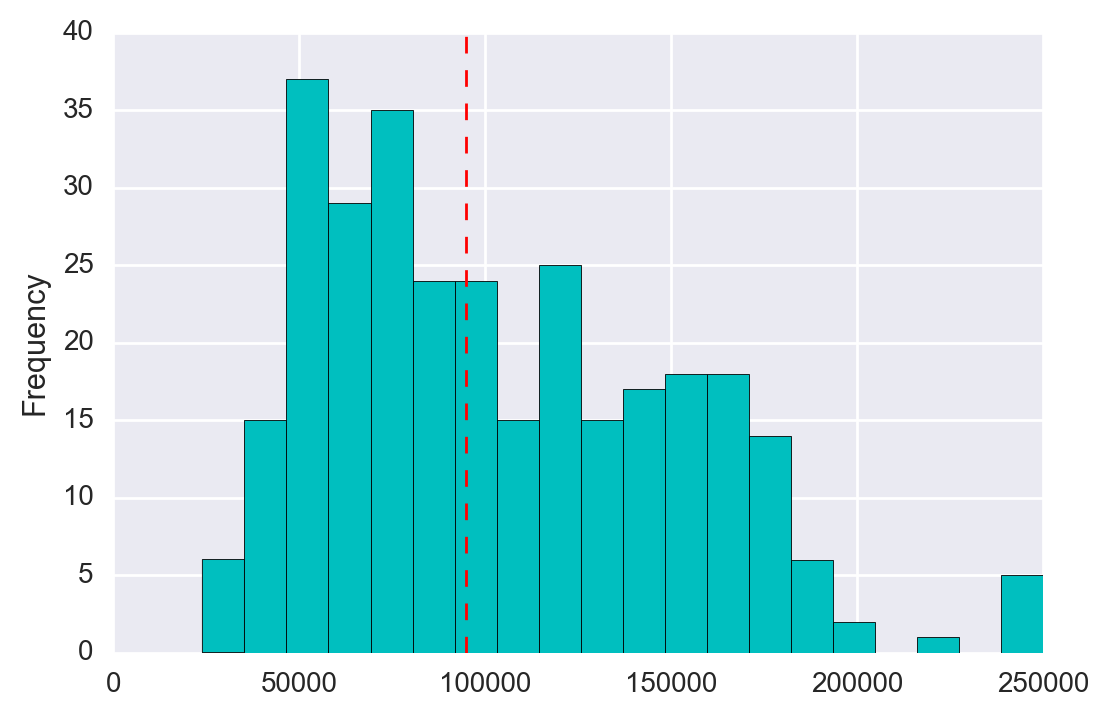

In [35]:

plt.figure()
jobs.Avg_salary.plot(kind='hist', color='c', bins=20)
plt.axvline(jobs.Avg_salary.median(), color='r', linestyle='dashed', linewidth=1)

plt.show()

There seems to be a couple of large outliers above 200k. Let's check if they are legitimate offers:

In [36]:
jobs[jobs["Avg_salary"] >200000]

,Company,Location,Search_City,Job_Title,Summary,Avg_salary
137,Harnham,"Chicago, IL",Chicago,Lead Data Scientist,This organization is looking for a lead data s...,250000.0
172,Harnham,"San Francisco, CA",San Francisco,Lead Data Scientist - Engagement & Growth,"Data Science, Data Scientist, Director, Head o...",220000.0
181,Redfish Technology,"Berkeley, CA 94705",San Francisco,Sr Data Scientist/Solution Architect,"As a Solution Architect, you are responsible f...",250000.0
235,Averity,"Philadelphia, PA",Philadelphia,Quantitative Analyst (Big Data Focus) at $10+ ...,Source and build large data sets to utilize yo...,250000.0
282,Harnham,"Washington, DC",Washington DC,SVP Big Data and Analytics,SVP Big Data and Analytics. You will manage an...,250000.0
289,Harnham,"Washington, DC",Washington DC,VP of Advanced Analytics,You will manage and develop a team of Data Sci...,250000.0


The above seem like legitimate job offers, just on the high end of data science career, so I'm going to keep them.

#### Creating binary variable (0 for LOW and 1 for HIGH salary)

In [37]:
jobs["Binary_Salary"] = jobs.Avg_salary.map(lambda x: 1 if x >= median_salary else 0)
jobs.Binary_Salary.value_counts()

1    154
0    152
Name: Binary_Salary, dtype: int64

#### Thought experiment: What is the baseline accuracy for this model?

Baseline would just be the mean of binary salary column, ie about 50%, as we have just 2 possible outocomes divided right in the middle by a median.

In [38]:
baseline = np.mean(jobs.Binary_Salary)
baseline

0.5032679738562091

#### Create a Logistic Regression model to predict High/Low salary using statsmodel. Start by ONLY using the location as a feature. Display the coefficients and write a short summary of what they mean.

#### Firstly, let's look at the probabilities of HIGH salary in all locations:


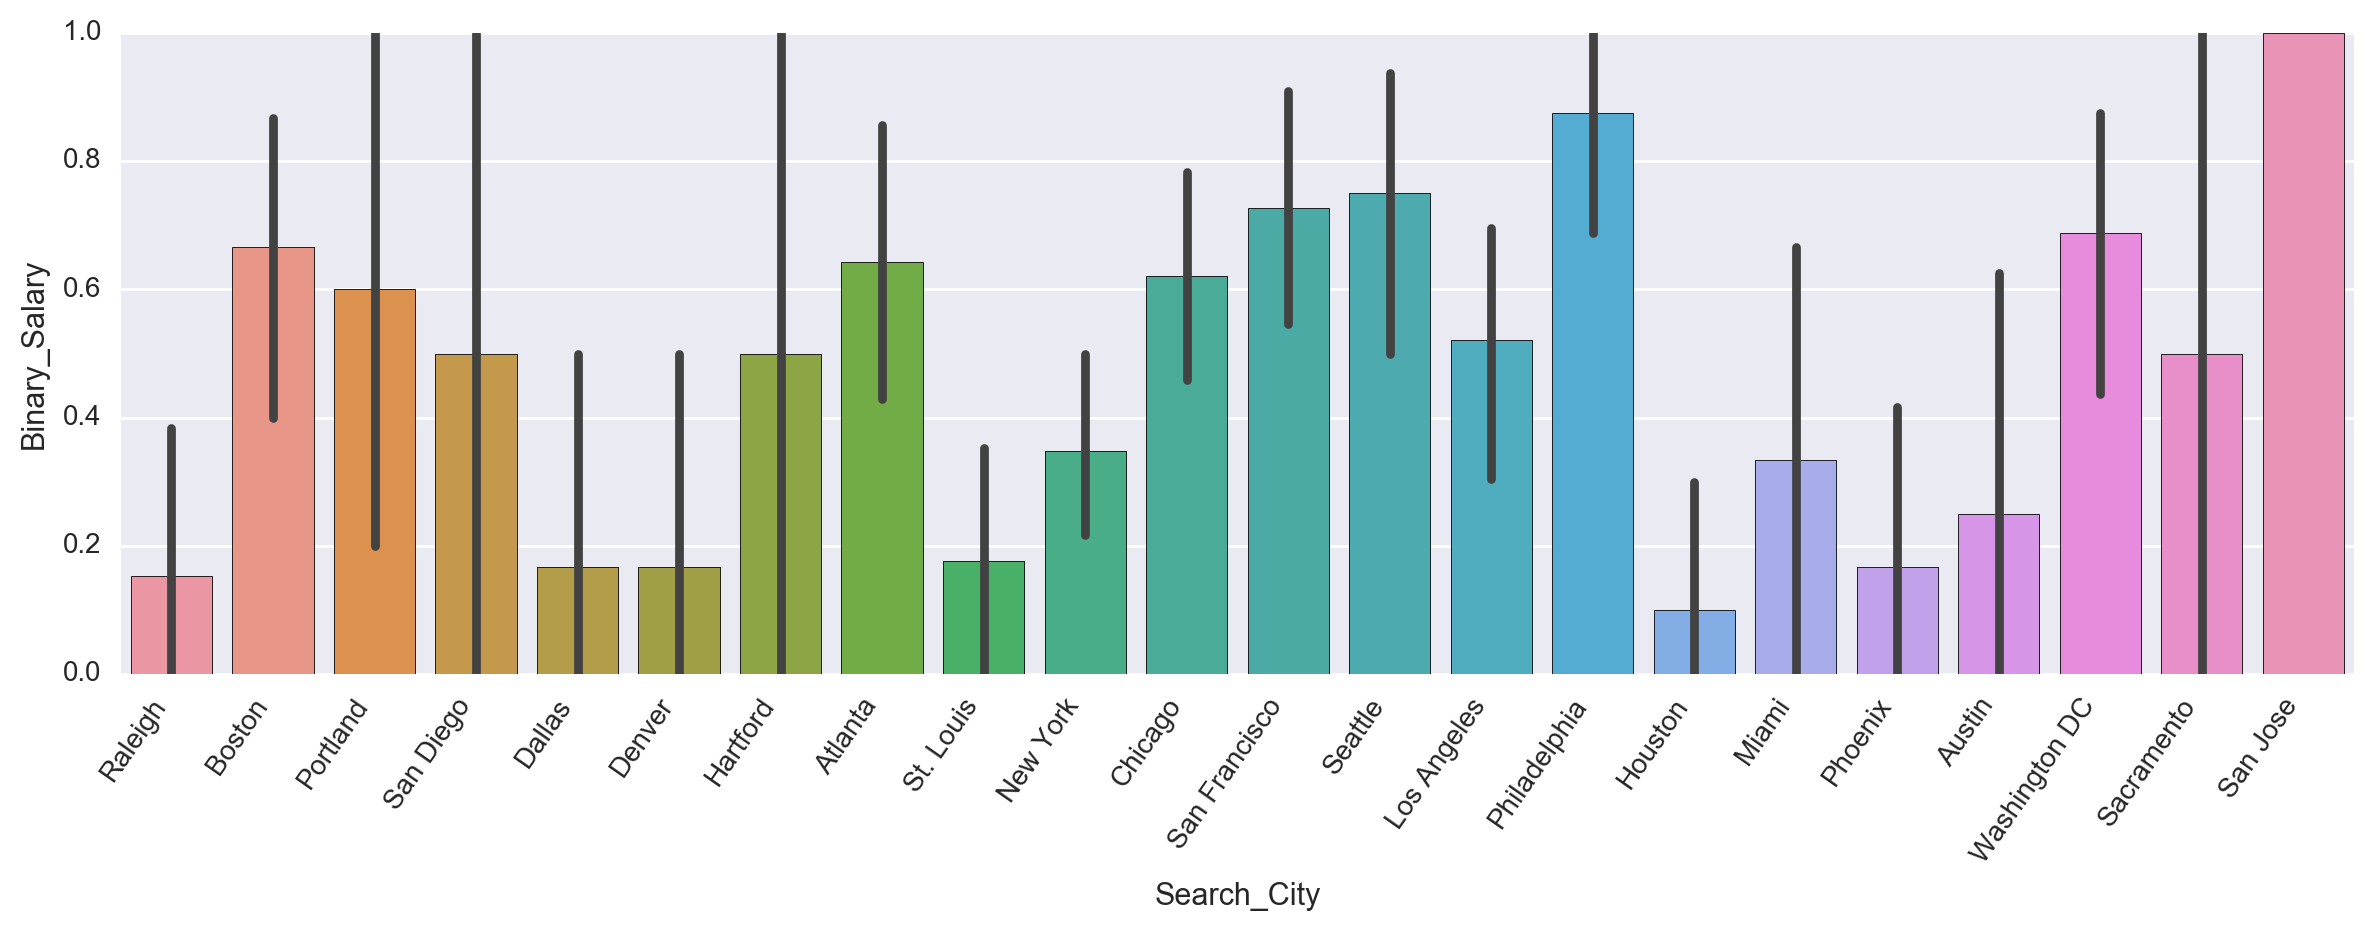

In [65]:
sns.factorplot(x='Search_City', y='Binary_Salary', 
               data=jobs, kind='bar', aspect=3).set_xticklabels(rotation=55, horizontalalignment='right')
plt.show()

From above chart it looks like San Jose , Philadelphia, San Francisco and Seattle have the highest ratios of HIGH salary.

#### Secondly, run the logistic regression with statsmodels:

In [39]:
loc_model = sm.logit("Binary_Salary ~ C(Search_City)", data=jobs).fit(method='ncg')
loc_model.summary()

Optimization terminated successfully.
         Current function value: 0.560469
         Iterations: 13
         Function evaluations: 14
         Gradient evaluations: 26
         Hessian evaluations: 13


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          Binary_Salary   No. Observations:                  306
Model:                          Logit   Df Residuals:                      284
Method:                           MLE   Df Model:                           21
Date:                Sat, 08 Apr 2017   Pseudo R-squ.:                  0.1914
Time:                        22:13:34   Log-Likelihood:                -171.50
converged:                       True   LL-Null:                       -212.10
                                        LLR p-value:                 5.111e-09
===================================================================================================
                                      coef    std err          z      P>|z|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------------------
Intercept                           0.5878      0.558      1.054      0.292        -0.505     1.681
C(Search_City)[T.Austin]           -1.6864      0.989     -1.705      0.088        -3.624     0.252
C(Search_City)[T.Boston]            0.1054      0.782      0.135      0.893        -1.427     1.638
C(Search_City)[T.Chicago]          -0.0914      0.653     -0.140      0.889        -1.371     1.188
C(Search_City)[T.Dallas]           -2.1972      1.229     -1.787      0.074        -4.607     0.212
C(Search_City)[T.Denver]           -2.1972      1.229     -1.787      0.074        -4.607     0.212
C(Search_City)[T.Hartford]         -0.5878      1.520     -0.387      0.699        -3.567     2.392
C(Search_City)[T.Houston]          -2.7850      1.193     -2.335      0.020        -5.122    -0.448
C(Search_City)[T.Los Angeles]      -0.5008      0.697     -0.719      0.472        -1.866     0.865
C(Search_City)[T.Miami]            -1.2809      1.030     -1.244      0.214        -3.300     0.738
C(Search_City)[T.New York]         -1.2164      0.638     -1.907      0.057        -2.467     0.034
C(Search_City)[T.Philadelphia]      1.3581      0.939      1.446      0.148        -0.483     3.199
C(Search_City)[T.Phoenix]          -2.1972      0.955     -2.302      0.021        -4.068    -0.326
C(Search_City)[T.Portland]         -0.1823      1.070     -0.170      0.865        -2.279     1.914
C(Search_City)[T.Raleigh]          -2.2925      0.950     -2.414      0.016        -4.154    -0.431
C(Search_City)[T.Sacramento]       -0.5878      1.520     -0.387      0.699        -3.567     2.392
C(Search_City)[T.San Diego]        -0.5878      1.145     -0.513      0.608        -2.832     1.656
C(Search_City)[T.San Francisco]     0.3930      0.735      0.535      0.593        -1.048     1.834
C(Search_City)[T.San Jose]         12.2655    195.456      0.063      0.950      -370.821   395.352
C(Search_City)[T.Seattle]           0.5108      0.803      0.636      0.525        -1.063     2.084
C(Search_City)[T.St. Louis]        -2.1282      0.846     -2.515      0.012        -3.787    -0.470
C(Search_City)[T.Washington DC]     0.2007      0.776      0.259      0.796        -1.320     1.721
===================================================================================================
"""

The estimated coefficients are the log odds. By exponentiating these values, we can calculate the odds, which are easier to interpret:

In [40]:
np.exp(loc_model.params)

Intercept                               1.800004
C(Search_City)[T.Austin]                0.185185
C(Search_City)[T.Boston]                1.111110
C(Search_City)[T.Chicago]               0.912695
C(Search_City)[T.Dallas]                0.111111
C(Search_City)[T.Denver]                0.111111
C(Search_City)[T.Hartford]              0.555555
C(Search_City)[T.Houston]               0.061728
C(Search_City)[T.Los Angeles]           0.606059
C(Search_City)[T.Miami]                 0.277775
C(Search_City)[T.New York]              0.296295
C(Search_City)[T.Philadelphia]          3.888873
C(Search_City)[T.Phoenix]               0.111112
C(Search_City)[T.Portland]              0.833335
C(Search_City)[T.Raleigh]               0.101010
C(Search_City)[T.Sacramento]            0.555555
C(Search_City)[T.San Diego]             0.555556
C(Search_City)[T.San Francisco]         1.481479
C(Search_City)[T.San Jose]         212235.703018
C(Search_City)[T.Seattle]               1.666665
C(Search_City)[T.St.

From the above we can see that San Jose is **extremely** well assosiated with HIGH salary. Odds of getting HIGH salary are also high in Philadelphia, Seattle and San Francisco.
Raleigh, Dallas, Denver, St.Louis, Phoenix and Austin have small odds of getting paid above the median.

#### Checking out San Jose jobs, as the result is very extreme:

In [68]:
jobs[jobs["Search_City"] == "San Jose"]

,Company,Location,Search_City,Job_Title,Summary,Avg_salary,Binary_Salary
296,Harnham,"Santa Clara, CA",San Jose,Senior Data Scientist - NLP & Linguistics,Senior Data Scientist - NLP & Linguistics. YOU...,155000.0,1
297,Workbridge Associates,"San Jose, CA 95113 (Downtown area)",San Jose,Senior Machine Learning Data Scientist,Leading provider of mortgage software solution...,150000.0,1
298,3coast,"San Jose, CA",San Jose,Senior AI Data Scientist,Senior AI Data Scientist. Do you thrive on dev...,175000.0,1
299,Jobspring Partners,"San Jose, CA 95113 (Downtown area)",San Jose,Machine Learning Engineer/Scientist,A Silicon Valley startup backed by world-renow...,162500.0,1
300,Jobspring Partners,"San Jose, CA 95113 (Downtown area)",San Jose,Machine Learning Software Engineer,"You will help design novel data structures, al...",150000.0,1
301,Jobspring Partners,"San Jose, CA 95113 (Downtown area)",San Jose,Machine Learning Infrastructure Engineer,You will play a critical role in building the ...,150000.0,1
302,Jobspring Partners,"San Jose, CA 95113 (Downtown area)",San Jose,Data Engineer,A well-known established company is looking fo...,147500.0,1
303,Jobspring Partners,"San Jose, CA 95113 (Downtown area)",San Jose,Big Data Engineer,Drawing on your depth of knowledge of the Hado...,155000.0,1
304,Elevate Recruiting Group,"Redwood City, CA",San Jose,Senior Data Scientist - Security Experience is...,Through the Our Clients pivotal world-view in ...,170000.0,1
305,Culver Careers,"San Jose, CA",San Jose,Systems Engineer (Pre-Sales): Big Data and Pre...,Big Data and Predictive Analytics Solutions. F...,145000.0,1


Jobs in San Jose are indeed on a very high end of the professional hierarchy with apropriate salaries.
Does it mean data scientists should all move to San Jose to earn more? Hard to say as there is no data for medium level and junior positions.

#### Create a few new variables in your dataframe to represent interesting features of a job title.
- For example, create a feature that represents whether 'Senior' is in the title 
- or whether 'Manager' is in the title. 
- Then build a new Logistic Regression model with these features. Do they add any value? 


In [41]:
# Convert job title to lowercase
jobs['Job_Title'] = jobs['Job_Title'].apply(lambda x: x.lower())

In [42]:
#Checking out job titles
jobs['Job_Title'].value_counts().head(10)

data scientist               11
senior data scientist         6
machine learning engineer     5
lead data scientist           5
data analyst                  3
research scientist            3
quantitative analyst          3
principal data scientist      3
data engineer                 3
certifying scientist          2
Name: Job_Title, dtype: int64

#### There is a large variety in position names. I'm going the extract the keywords that might indicate higher salary and add them as binary columns: 

In [43]:
jobs['is_senior'] = jobs['Job_Title'].str.contains('senior').astype(int)
jobs['is_vp'] = jobs['Job_Title'].str.contains('vp').astype(int) 
jobs['is_mgr'] = jobs['Job_Title'].str.contains('manager').astype(int)
jobs['is_lead'] = jobs['Job_Title'].str.contains('lead').astype(int)
jobs['is_prin'] = jobs['Job_Title'].str.contains('principal').astype(int)
jobs['is_eng'] = jobs['Job_Title'].str.contains('engineer').astype(int)

In [44]:
jobs.head(2)

,Company,Location,Search_City,Job_Title,Summary,Avg_salary,Binary_Salary,is_senior,is_vp,is_mgr,is_lead,is_prin,is_eng
0,University of North Carolina,"Chapel Hill, NC 27517",Raleigh,research specialist,Prepare posters and other materials for presen...,43854.5,0,0,0,0,0,0,0
1,State of North Carolina,"Wake County, NC",Raleigh,medicaid statistician,"This is a technical position, involving the an...",58617.5,0,0,0,0,0,0,0


#### Running logistic regression in statsmodels:

In [45]:
loc_model = sm.logit("Binary_Salary ~ C(Search_City) + is_senior + is_vp + is_mgr + is_lead + is_prin + is_eng", data=jobs).fit(method='ncg')
loc_model.summary()

Optimization terminated successfully.
         Current function value: 0.478778
         Iterations: 15
         Function evaluations: 16
         Gradient evaluations: 30
         Hessian evaluations: 15


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          Binary_Salary   No. Observations:                  306
Model:                          Logit   Df Residuals:                      278
Method:                           MLE   Df Model:                           27
Date:                Sat, 08 Apr 2017   Pseudo R-squ.:                  0.3092
Time:                        22:14:04   Log-Likelihood:                -146.51
converged:                       True   LL-Null:                       -212.10
                                        LLR p-value:                 1.207e-15
===================================================================================================
                                      coef    std err          z      P>|z|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------------------
Intercept                           0.2004      0.590      0.340      0.734        -0.955     1.356
C(Search_City)[T.Austin]           -1.8943      1.073     -1.766      0.077        -3.997     0.209
C(Search_City)[T.Boston]           -0.5912      0.861     -0.686      0.492        -2.279     1.097
C(Search_City)[T.Chicago]          -0.3937      0.700     -0.562      0.574        -1.766     0.979
C(Search_City)[T.Dallas]           -2.3916      1.289     -1.855      0.064        -4.919     0.136
C(Search_City)[T.Denver]           -2.5866      1.435     -1.802      0.071        -5.399     0.226
C(Search_City)[T.Hartford]         -2.7229      1.639     -1.662      0.097        -5.935     0.489
C(Search_City)[T.Houston]          -3.0424      1.274     -2.389      0.017        -5.539    -0.546
C(Search_City)[T.Los Angeles]      -0.7752      0.761     -1.019      0.308        -2.267     0.716
C(Search_City)[T.Miami]            -1.4287      1.127     -1.267      0.205        -3.638     0.781
C(Search_City)[T.New York]         -1.6020      0.699     -2.293      0.022        -2.971    -0.233
C(Search_City)[T.Philadelphia]      1.4981      0.967      1.549      0.121        -0.397     3.393
C(Search_City)[T.Phoenix]          -1.9672      0.983     -2.000      0.045        -3.895    -0.040
C(Search_City)[T.Portland]          0.0972      1.097      0.089      0.929        -2.053     2.247
C(Search_City)[T.Raleigh]          -1.9052      0.969     -1.966      0.049        -3.804    -0.006
C(Search_City)[T.Sacramento]       -0.2004      1.532     -0.131      0.896        -3.204     2.803
C(Search_City)[T.San Diego]        -0.9165      1.290     -0.711      0.477        -3.444     1.611
C(Search_City)[T.San Francisco]     0.0293      0.786      0.037      0.970        -1.512     1.570
C(Search_City)[T.San Jose]         11.2263    237.515      0.047      0.962      -454.294   476.746
C(Search_City)[T.Seattle]           0.3482      0.848      0.411      0.681        -1.314     2.010
C(Search_City)[T.St. Louis]        -1.9580      0.878     -2.230      0.026        -3.679    -0.237
C(Search_City)[T.Washington DC]    -0.0106      0.832     -0.013      0.990        -1.641     1.620
is_senior                           1.3387      0.441      3.034      0.002         0.474     2.203
is_vp                              13.4313    237.515      0.057      0.955      -452.090   478.952
is_mgr                              0.5717      0.662      0.863      0.388        -0.727     1.870
is_lead                             2.7041      0.921      2.937      0.003         0.899     4.509
is_prin                            12.1556    237.515      0.051      0.959      -453.365   477.676
is_eng                              2.3409      0.647      3.616      0.000         1.072     3.610
===================================================================================================
"""

#### Rebuild this model with scikit-learn.
- You can either create the dummy features manually or use the `dmatrix` function from `patsy`
- Remember to scale the feature variables as well!


In [46]:
#Creating design matrix:

titles_formula = '~ C(Search_City) + is_senior + is_vp + is_mgr + is_lead + is_prin + is_eng' #-1

X = patsy.dmatrix(titles_formula, data=jobs, return_type='dataframe')
y = jobs.Binary_Salary.values

print X.shape
print y.shape

(306, 28)
(306,)


In [47]:
#Running logistic regression in Scikit Learn:

logreg = LogisticRegression(C=10**10,solver='lbfgs')
logreg.fit(X, y)

print 'Logreg intercept:', logreg.intercept_
print 'Logreg coef(s):', logreg.coef_

Logreg intercept: [ 0.09932593]
Logreg coef(s): [[  9.93259240e-02  -1.89224257e+00  -5.88867425e-01  -3.91482116e-01
   -2.38797145e+00  -2.58453000e+00  -2.72104674e+00  -3.04008838e+00
   -7.73527612e-01  -1.42787158e+00  -1.59969259e+00   1.50033847e+00
   -1.96472183e+00   9.97358123e-02  -1.90320170e+00  -2.00302218e-01
   -9.14701888e-01   3.08229427e-02   1.20959148e+01   3.49978486e-01
   -1.95553071e+00  -8.89025043e-03   1.33800688e+00   1.60665879e+01
    5.71305114e-01   2.70417502e+00   1.66632516e+01   2.34102814e+00]]


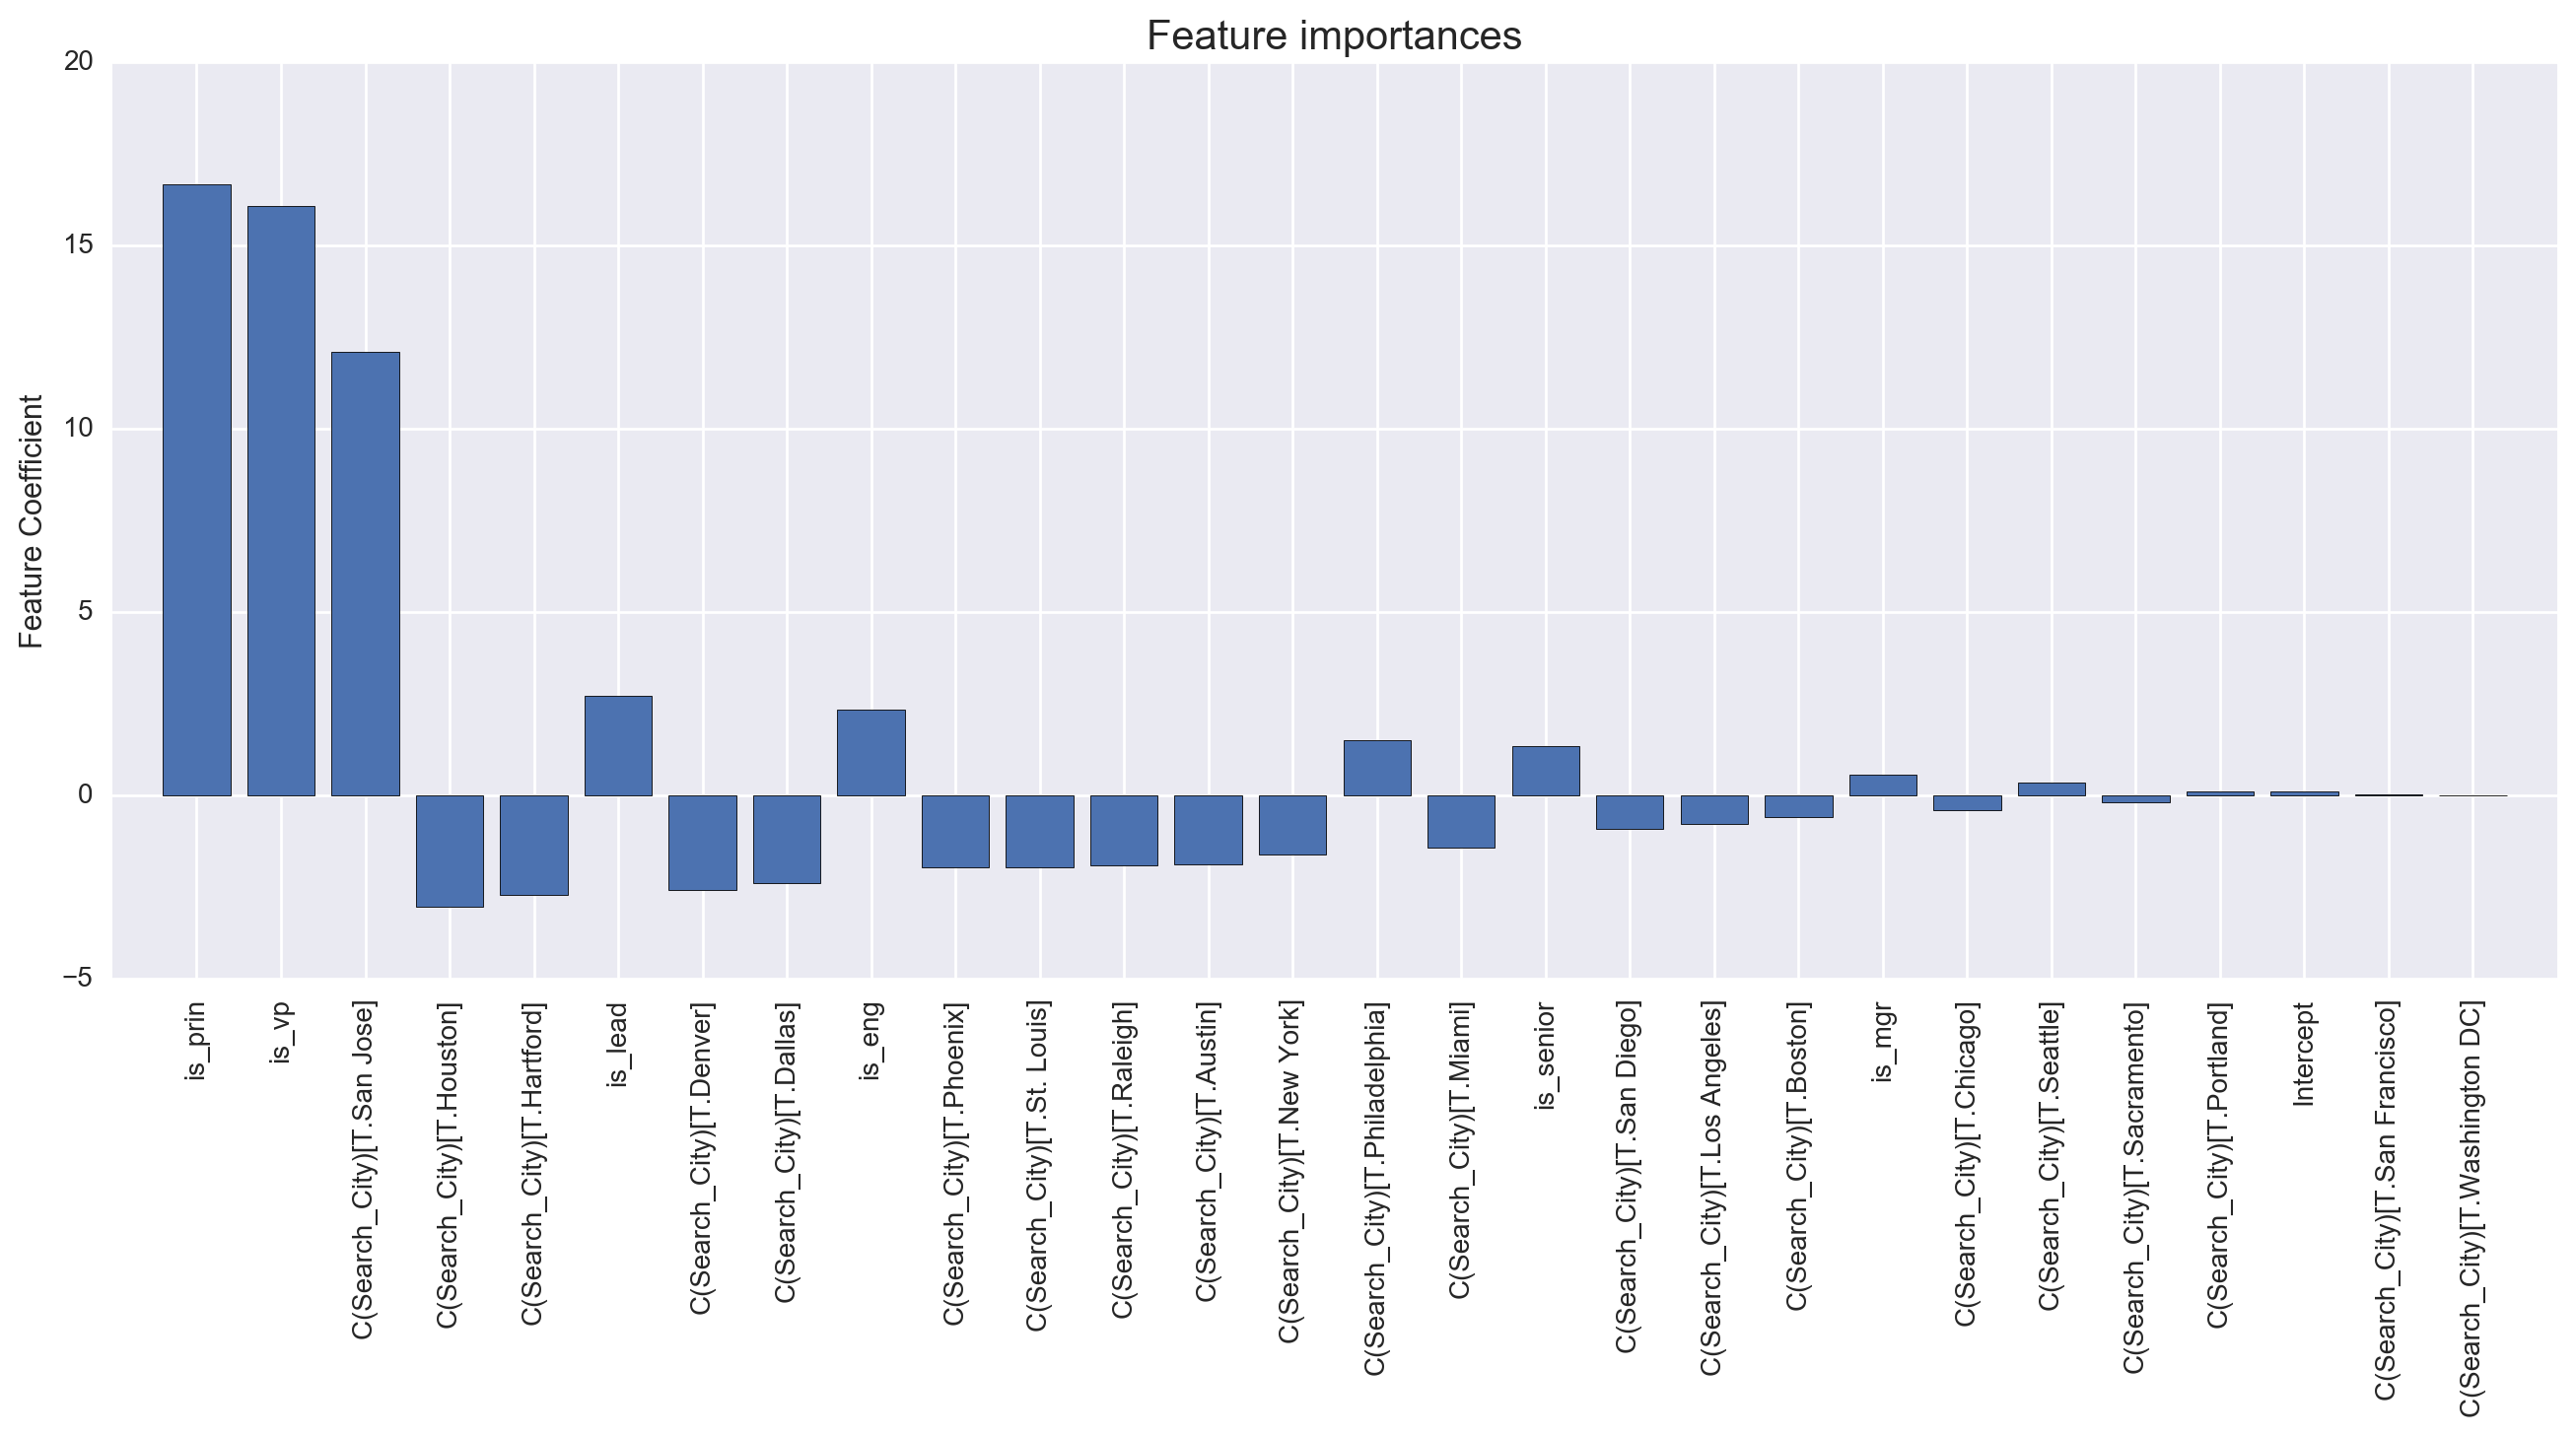

In [48]:
#Plotting feature importances:
importances = logreg.coef_ # feature importance
indices = np.argsort(np.absolute(importances))# sort importance

# Plot the feature importances
plt.figure(figsize = (16, 6))
plt.title("Feature importances", fontsize = 15)
plt.bar(range(X.shape[1]), importances[0][indices][0][::-1], align="center")
plt.ylabel('Feature Coefficient')
plt.xticks(range(X.shape[1]), X.columns[indices][0][::-1], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

From the above chart we can see that keywords like 'principal' and 'vp' in job titles are very well associated with high salaries. Similarly 'lead', 'engineer' and 'senior' and 'manager' are positively associated with high salary though not in as extreme way as two first keywords. Further we can see that again San Jose, Philadelphia and Seattle are locations where chances of getting salary above median are quite high.

#### Comparing coefficients by statsmodels and scikit learn:

In [49]:
coefs_df = pd.DataFrame({'variable':X.columns,
                         'statsm coef' : loc_model.params.values, #[1:]
                            'scikit coef':logreg.coef_[0]
                            })
coefs_df = coefs_df[['variable', 'statsm coef', 'scikit coef']]
coefs_df

,variable,statsm coef,scikit coef
0,Intercept,0.200413,0.099326
1,C(Search_City)[T.Austin],-1.894337,-1.892243
2,C(Search_City)[T.Boston],-0.591196,-0.588867
3,C(Search_City)[T.Chicago],-0.393657,-0.391482
4,C(Search_City)[T.Dallas],-2.391596,-2.387971
5,C(Search_City)[T.Denver],-2.586579,-2.584530
6,C(Search_City)[T.Hartford],-2.722925,-2.721047
7,C(Search_City)[T.Houston],-3.042390,-3.040088
8,C(Search_City)[T.Los Angeles],-0.775177,-0.773528
9,C(Search_City)[T.Miami],-1.428747,-1.427872


The results are very similar, but it looks like Scikit Learn favourizes larger coefficients (for 'San Jose', 'vp' and 'principal' categories).

#### Use cross-validation in scikit-learn to evaluate the model above. 
- Evaluate the accuracy, AUC, precision and recall of the model. 
- Discuss the differences and explain when you want a high-recall or a high-precision model in this scenario.

In [50]:
print 'Accuracy Score', cross_val_score(logreg,X,y,cv=5).mean()
conf_matrix = (confusion_matrix(y, cross_val_predict(logreg,X ,y ,cv=5)))
print 100*'-'
print 'Confusion matrix'
print pd.DataFrame(conf_matrix)
print 100*'-'
print "Classification report"
print classification_report(y,cross_val_predict(logreg,X,y,cv=5))
print 100*'-'
Y_score = logreg.decision_function(X)
print 'AUC:', roc_auc_score(y, Y_score)

Accuracy Score 0.487632645866
----------------------------------------------------------------------------------------------------
Confusion matrix
    0   1
0  68  84
1  73  81
----------------------------------------------------------------------------------------------------
Classification report
             precision    recall  f1-score   support

          0       0.48      0.45      0.46       152
          1       0.49      0.53      0.51       154

avg / total       0.49      0.49      0.49       306

----------------------------------------------------------------------------------------------------
AUC: 0.843109193438


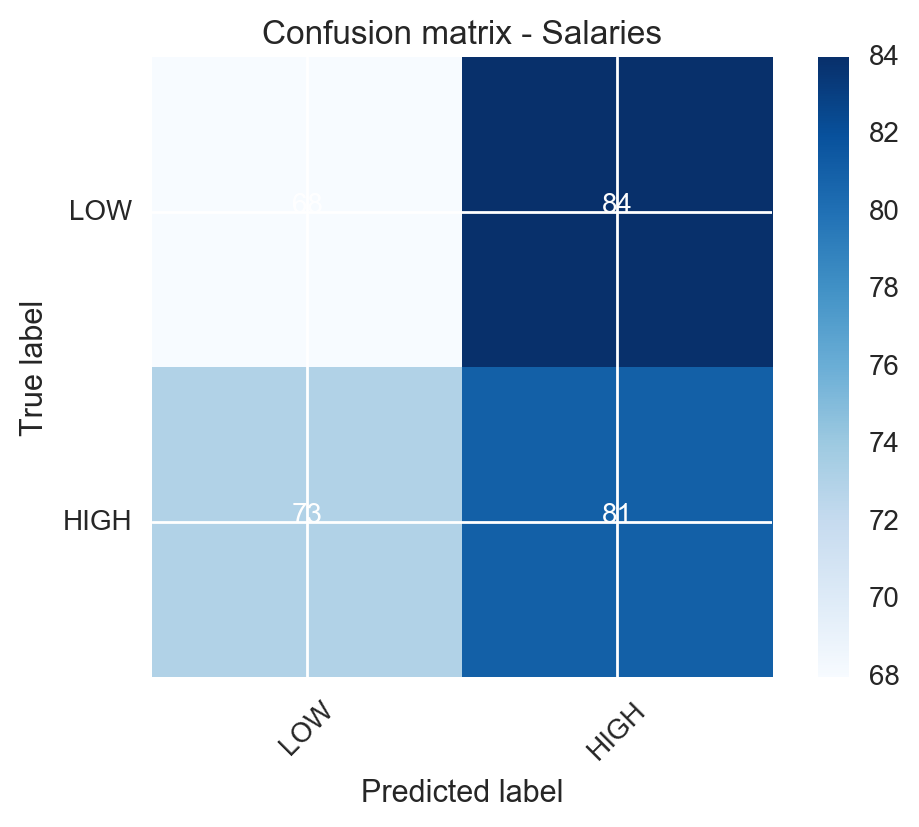

In [51]:
#Plotting confusion matrix

# Function for plotting confusion matrix
def plot_confusion_matrix(cm, classes, title, cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    return

plot_confusion_matrix(conf_matrix, 
                      title='Confusion matrix - Salaries', 
                      classes=['LOW','HIGH'])

#### ROC Curve

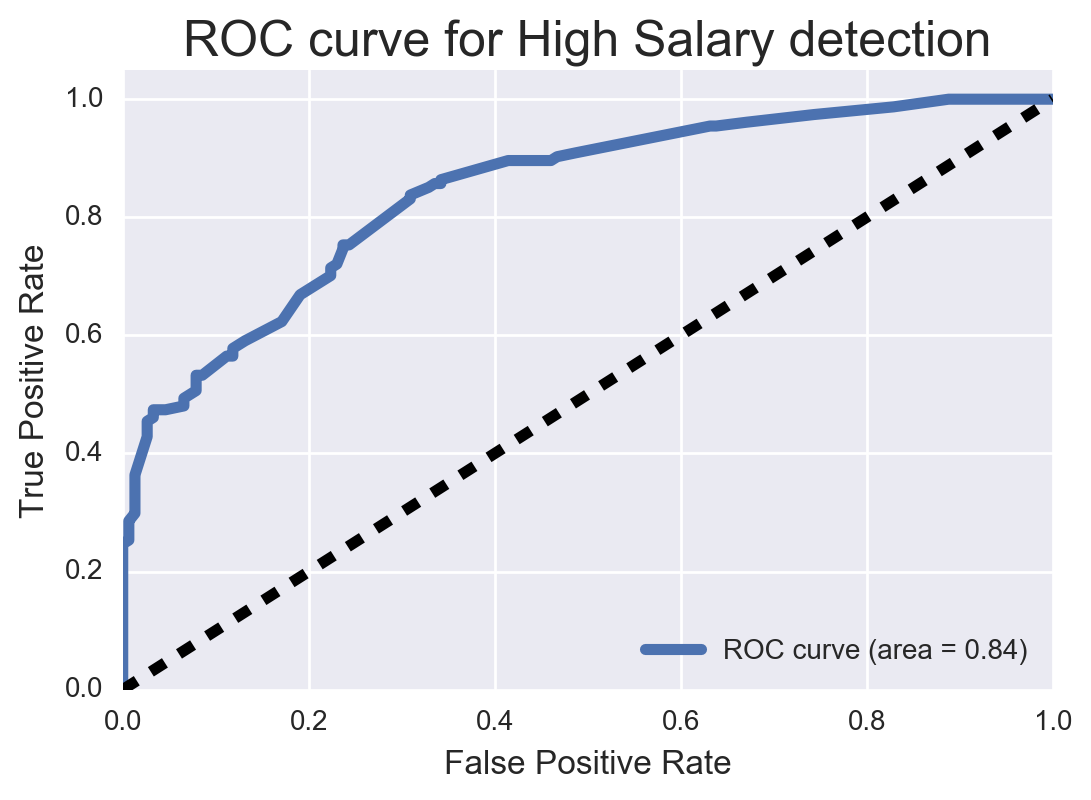

In [52]:
FPR, TPR, THR = roc_curve(y, Y_score)
ROC_AUC = auc(FPR, TPR)

# Plot of a ROC curve for class 1
plt.plot(FPR, TPR, label='ROC curve (area = %0.2f)' % ROC_AUC, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC curve for High Salary detection', fontsize=18)
plt.legend(loc="lower right")
plt.show()

Accuracy of the above model (a measure of correctness for all guesses) is 0.49 and it is lower than the baseline model accuracy of 0.50, indicating that the model is not better than guessing by chance. However accuracy alone is not enough to evaluate a model, so let's look at other metrics:

Precision of the model is 0.49 while recall is 0.49.

Precision answers the question: out of all the observations the classifier labeled as HIGH, what fraction were correct? On the other hand, recall answers: out of all the HIGH observations there were, what fraction did the classifier pick up?

When a model has lower precision and higher recall it means that it's more optimistic(predicts a lot of observations as HIGH). When a model has higher precision and lower recall it means that it's more pessimistic (predicts observations as HIGH only when sure).

As our company would rather tell a contractor incorrectly that they would get a lower salary job than tell a consumer incorrectly that they would get a high salary job I would recommend using a 'pessimistic' model, with higher precision and lower recall. This model works but is not perfect for our purpose, so let's construct another one.

#### Compare L1 and L2 regularization for this logistic regression model. What effect does this have on the coefficients learned?

In [53]:
#Running logistic regression with L1 penalty:

lr_lasso = LogisticRegression(penalty='l1', solver='liblinear')
lr_lasso.fit(X, y)

print 'Logreg intercept:', lr_lasso.intercept_
print 'Logreg coef(s):', lr_lasso.coef_

Logreg intercept: [-0.26317226]
Logreg coef(s): [[-0.04363882 -0.59654577  0.          0.16138434 -0.78788304 -0.68723727
   0.         -1.47978342  0.          0.         -0.70691965  1.59188838
  -0.9015643   0.         -0.89719296  0.          0.          0.4266404
   1.00816341  0.62345729 -1.02905893  0.3025637   1.0887329   2.02894673
   0.16612317  1.61060065  0.80022175  1.86560359]]


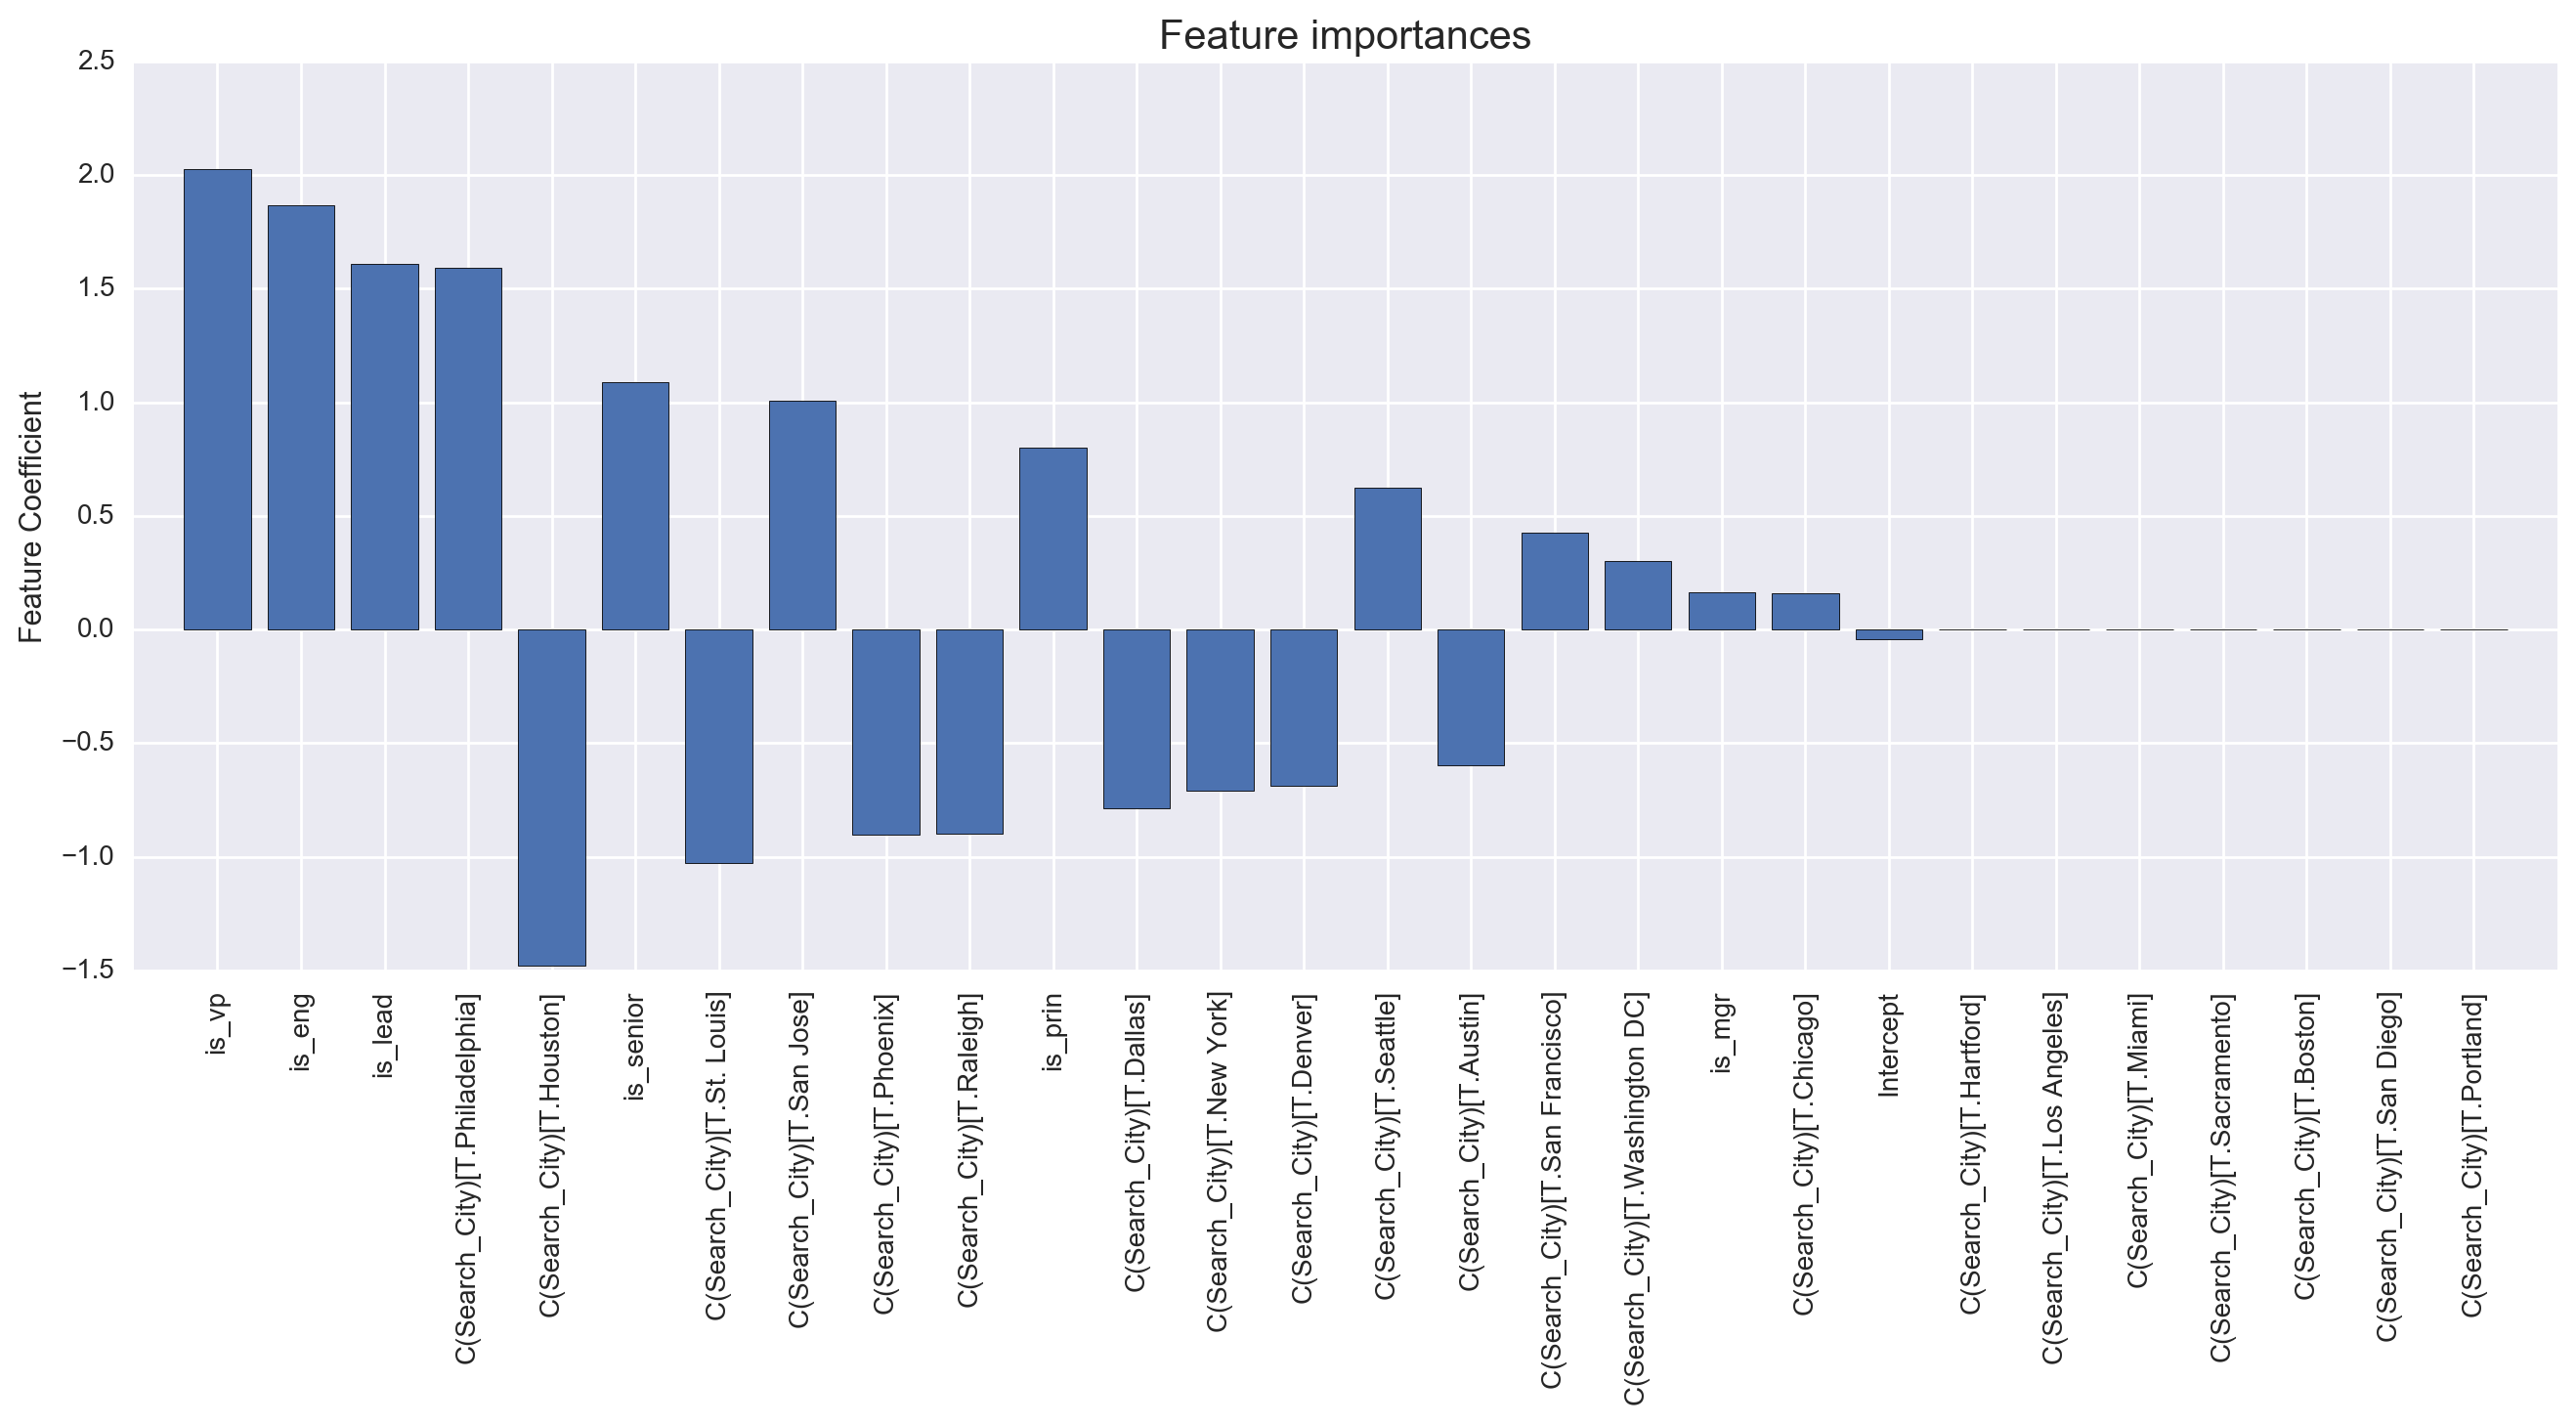

In [54]:
#Plotting importances
importances = lr_lasso.coef_ # feature importance
indices = np.argsort(np.absolute(importances))# sort importance

# Plot the feature importances
plt.figure(figsize = (16, 6))
plt.title("Feature importances", fontsize = 15)
plt.bar(range(X.shape[1]), importances[0][indices][0][::-1], align="center")
plt.ylabel('Feature Coefficient')
plt.xticks(range(X.shape[1]), X.columns[indices][0][::-1], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

In [55]:
#Running logistic regression with L2 penalty:

lr_ridge = LogisticRegression(penalty='l2', solver='liblinear')
lr_ridge.fit(X, y)

print 'Ridge intercept:', lr_ridge.intercept_
print 'Ridge coef(s):', lr_ridge.coef_

Ridge intercept: [-0.18811859]
Ridge coef(s): [[-0.18811859 -0.6882495   0.15398993  0.32973203 -0.83672392 -0.7749759
  -0.38359189 -1.22766682  0.0135154  -0.39253965 -0.64611063  1.46070695
  -0.88227255  0.38720177 -0.8803398   0.12499856 -0.0340612   0.61281989
   1.0844965   0.77361178 -0.9653334   0.55722474  1.0527077   1.43498392
   0.4022553   1.44809947  0.93066275  1.69453389]]


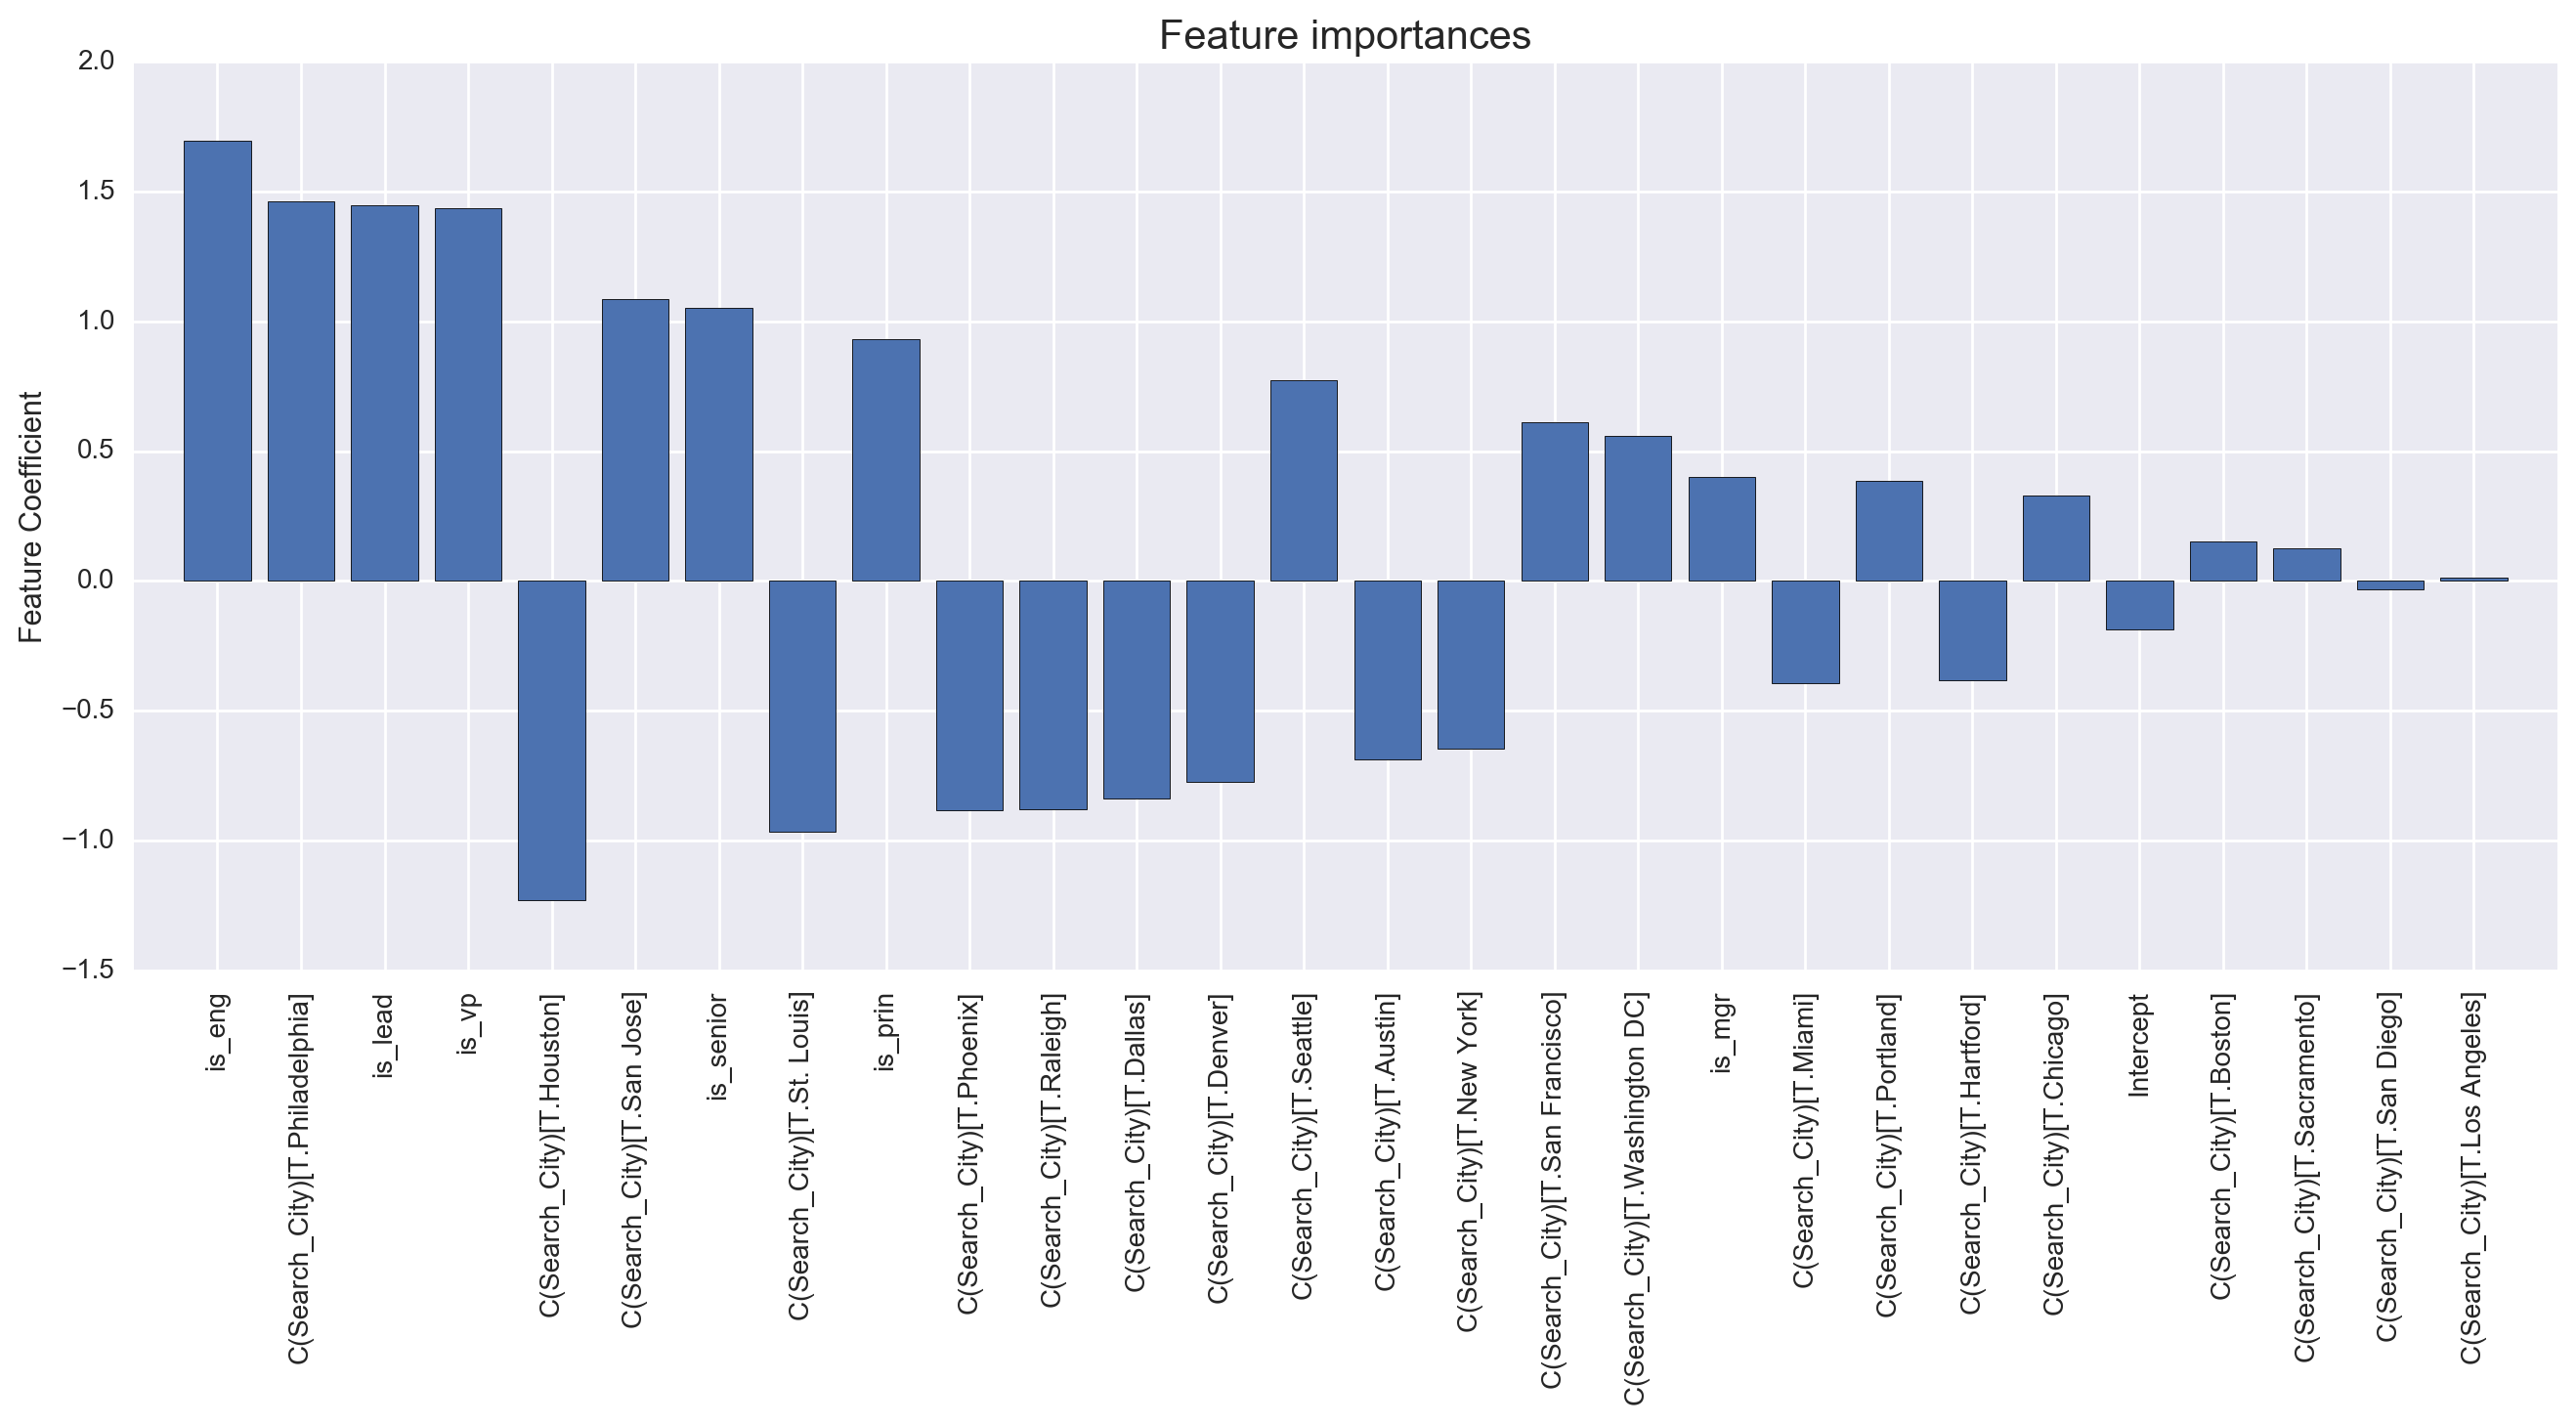

In [56]:
#Plotting importances
importances = lr_ridge.coef_ # feature importance
indices = np.argsort(np.absolute(importances))# sort importance

# Plot the feature importances
plt.figure(figsize = (16, 6))
plt.title("Feature importances", fontsize = 15)
plt.bar(range(X.shape[1]), importances[0][indices][0][::-1], align="center")
plt.ylabel('Feature Coefficient')
plt.xticks(range(X.shape[1]), X.columns[indices][0][::-1], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

To compare with coefficients from previous regressions, I'll append the results to the df with coefficients created earlier:

In [57]:
coefs_df["lasso"] = lr_lasso.coef_[0]
coefs_df["ridge"] = lr_ridge.coef_[0]
coefs_df

,variable,statsm coef,scikit coef,lasso,ridge
0,Intercept,0.200413,0.099326,-0.043639,-0.188119
1,C(Search_City)[T.Austin],-1.894337,-1.892243,-0.596546,-0.688249
2,C(Search_City)[T.Boston],-0.591196,-0.588867,0.000000,0.153990
3,C(Search_City)[T.Chicago],-0.393657,-0.391482,0.161384,0.329732
4,C(Search_City)[T.Dallas],-2.391596,-2.387971,-0.787883,-0.836724
5,C(Search_City)[T.Denver],-2.586579,-2.584530,-0.687237,-0.774976
6,C(Search_City)[T.Hartford],-2.722925,-2.721047,0.000000,-0.383592
7,C(Search_City)[T.Houston],-3.042390,-3.040088,-1.479783,-1.227667
8,C(Search_City)[T.Los Angeles],-0.775177,-0.773528,0.000000,0.013515
9,C(Search_City)[T.Miami],-1.428747,-1.427872,0.000000,-0.392540


From above we can see both lasso and ridge shrinked coeficcients considerably, especially the large ones, bringing the 'engineer' and 'Philadelphia' feature to the top. Lasso also simplified our model quite a lot and removed some coefficients.


Let's check the models' metrics:

In [58]:
print "LASSO METRICS"
print 100*'-'
print 'Accuracy Score', cross_val_score(lr_lasso,X,y,cv=5).mean()
conf_matrix = (confusion_matrix(y, cross_val_predict(lr_lasso, X ,y ,cv=5)))
print 100*'-'
print 'Confusion matrix'
print pd.DataFrame(conf_matrix)
print 100*'-'
print "Classification report"
print classification_report(y,cross_val_predict(lr_lasso,X,y,cv=5))
print 100*'-'
Y_score = lr_lasso.decision_function(X)
print 'AUC:', roc_auc_score(y, Y_score)

LASSO METRICS
----------------------------------------------------------------------------------------------------
Accuracy Score 0.611716904636
----------------------------------------------------------------------------------------------------
Confusion matrix
     0   1
0  116  36
1   83  71
----------------------------------------------------------------------------------------------------
Classification report
             precision    recall  f1-score   support

          0       0.58      0.76      0.66       152
          1       0.66      0.46      0.54       154

avg / total       0.62      0.61      0.60       306

----------------------------------------------------------------------------------------------------
AUC: 0.831467874231


In [59]:
print "RIDGE METRICS"
print 100*'-'
print 'Accuracy Score', cross_val_score(lr_ridge,X,y,cv=5).mean()
conf_matrix = (confusion_matrix(y, cross_val_predict(lr_ridge, X ,y ,cv=5)))
print 100*'-'
print 'Confusion matrix'
print pd.DataFrame(conf_matrix)
print 100*'-'
print "Classification report"
print classification_report(y,cross_val_predict(lr_ridge,X,y,cv=5))
print 100*'-'
Y_score = lr_ridge.decision_function(X)
print 'AUC:', roc_auc_score(y, Y_score)

RIDGE METRICS
----------------------------------------------------------------------------------------------------
Accuracy Score 0.602515423938
----------------------------------------------------------------------------------------------------
Confusion matrix
     0   1
0  101  51
1   71  83
----------------------------------------------------------------------------------------------------
Classification report
             precision    recall  f1-score   support

          0       0.59      0.66      0.62       152
          1       0.62      0.54      0.58       154

avg / total       0.60      0.60      0.60       306

----------------------------------------------------------------------------------------------------
AUC: 0.834906869446


Both penalties seem to perform better than original logistic regression, with increased accuracy, precision and recall. To make sure we get the best settings for both, let's look at GridSearchCv:

In [60]:
search_parameters = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'penalty': ['l1','l2']}
grid = GridSearchCV(LogisticRegression(), search_parameters, cv=5)
grid.fit(X, y)
print grid.best_params_

{'penalty': 'l2', 'C': 0.1}


In [82]:
#Running ridge regression with above params:

lr_ridge2 = LogisticRegression(penalty='l2', C=0.1, solver='liblinear')
lr_ridge2.fit(X, y)

print 'Ridge2 intercept:', lr_ridge2.intercept_
print 'Ridge2 coef(s):', lr_ridge2.coef_

Ridge2 intercept: [-0.0803999]
Ridge2 coef(s): [[-0.0803999  -0.16596871  0.10778384  0.20640139 -0.17491271 -0.16179874
  -0.01902252 -0.31404013  0.01919185 -0.08475964 -0.3216093   0.44331051
  -0.28168466  0.05949844 -0.30216337  0.00763952  0.00280812  0.27595203
   0.31144358  0.26816422 -0.35854127  0.20698547  0.49963727  0.24956164
   0.12632393  0.39393444  0.19305738  0.74253713]]


In [155]:
#Checking metrics for the new model
print "RIDGE2 METRICS"
print 100*'-'
print 'Accuracy Score', cross_val_score(lr_ridge2,X,y,cv=5).mean()
conf_matrix = (confusion_matrix(y, cross_val_predict(lr_ridge2, X ,y ,cv=5)))
print 100*'-'
print 'Confusion matrix'
print pd.DataFrame(conf_matrix)
print 100*'-'
print "Classification report"
print classification_report(y,cross_val_predict(lr_ridge2,X,y,cv=5))
print 100*'-'
Y_score = lr_ridge2.decision_function(X)
print 'AUC:', roc_auc_score(y, Y_score)

RIDGE2 METRICS
----------------------------------------------------------------------------------------------------
Accuracy Score 0.621607615019
----------------------------------------------------------------------------------------------------
Confusion matrix
     0   1
0  114  38
1   78  76
----------------------------------------------------------------------------------------------------
Classification report
             precision    recall  f1-score   support

          0       0.59      0.75      0.66       152
          1       0.67      0.49      0.57       154

avg / total       0.63      0.62      0.61       306

----------------------------------------------------------------------------------------------------
AUC: 0.810769822283


Accuracy, precision and recall increased very slightly indicating that this model performs better than the previous ones.

#### Continue to incorporate other text features from the title or summary that you believe will predict the salary and examine their coefficients

Adding couple of keywords from summary column:

In [62]:
keywords = ['hadoop', 'spark', 'algorithm', 'big data']

In [63]:
jobs['Summary'] = jobs['Summary'].apply(lambda x: x.lower())

In [64]:
jobs['has_hadoop'] = jobs['Summary'].str.contains('hadoop').astype(int)
jobs['has_spark'] = jobs['Summary'].str.contains('spark').astype(int) 
jobs['has_algorithm'] = jobs['Summary'].str.contains('algorithm').astype(int)
jobs['has_bigdata'] = jobs['Summary'].str.contains('big data').astype(int)

In [65]:
jobs.head(2)

,Company,Location,Search_City,Job_Title,Summary,Avg_salary,Binary_Salary,is_senior,is_vp,is_mgr,is_lead,is_prin,is_eng,has_hadoop,has_spark,has_algorithm,has_bigdata
0,University of North Carolina,"Chapel Hill, NC 27517",Raleigh,research specialist,prepare posters and other materials for presen...,43854.5,0,0,0,0,0,0,0,0,0,0,0
1,State of North Carolina,"Wake County, NC",Raleigh,medicaid statistician,"this is a technical position, involving the an...",58617.5,0,0,0,0,0,0,0,0,0,0,0


In [66]:
#Checking for number of keywords in column
for col in jobs:
    if 'has' in col:
        print col, np.sum(jobs[col])

has_hadoop 12
has_spark 7
has_algorithm 11
has_bigdata 17


Incorporate new columns in predictor matrix and "Ridge2" logistic regression:

In [67]:
#Creating design matrix:

titles_formula = '~ C(Search_City) + is_senior + is_vp + is_mgr + is_lead + is_prin + is_eng + has_hadoop + has_spark + has_algorithm + has_bigdata -1'

X_has = patsy.dmatrix(titles_formula, data=jobs, return_type='dataframe')
y = jobs.Binary_Salary.values

print X_has.shape
print y.shape

(306, 32)
(306,)


In [68]:
#Running logistic regression in Scikit Learn:

lr_ridge2 = LogisticRegression(penalty='l2', C=0.1, solver='liblinear')
lr_ridge2.fit(X_has, y)

print 'Logreg intercept:', lr_ridge2.intercept_
print 'Logreg coef(s):', lr_ridge2.coef_

Logreg intercept: [-0.16488812]
Logreg coef(s): [[ 0.14741214 -0.16450646  0.10133332  0.20480123 -0.17559425 -0.16272299
  -0.01978698 -0.31247533  0.01557146 -0.08372554 -0.31956627  0.4412531
  -0.28059415  0.05834068 -0.30120508  0.0078288   0.00341384  0.26203613
   0.30996288  0.26947803 -0.35703091  0.19088822  0.49013189  0.24900501
   0.12391722  0.38567355  0.19435628  0.71998381  0.24696233  0.12104592
  -0.00371948  0.07465544]]


In [69]:
#Looking at coefficients:
coefs_has = pd.DataFrame({'variable':X_has.columns,
                            'coefs':lr_ridge2.coef_[0]
                            })
coefs_has = coefs_has[['variable', 'coefs']]
coefs_has

,variable,coefs
0,C(Search_City)[Atlanta],0.147412
1,C(Search_City)[Austin],-0.164506
2,C(Search_City)[Boston],0.101333
3,C(Search_City)[Chicago],0.204801
4,C(Search_City)[Dallas],-0.175594
5,C(Search_City)[Denver],-0.162723
6,C(Search_City)[Hartford],-0.019787
7,C(Search_City)[Houston],-0.312475
8,C(Search_City)[Los Angeles],0.015571
9,C(Search_City)[Miami],-0.083726


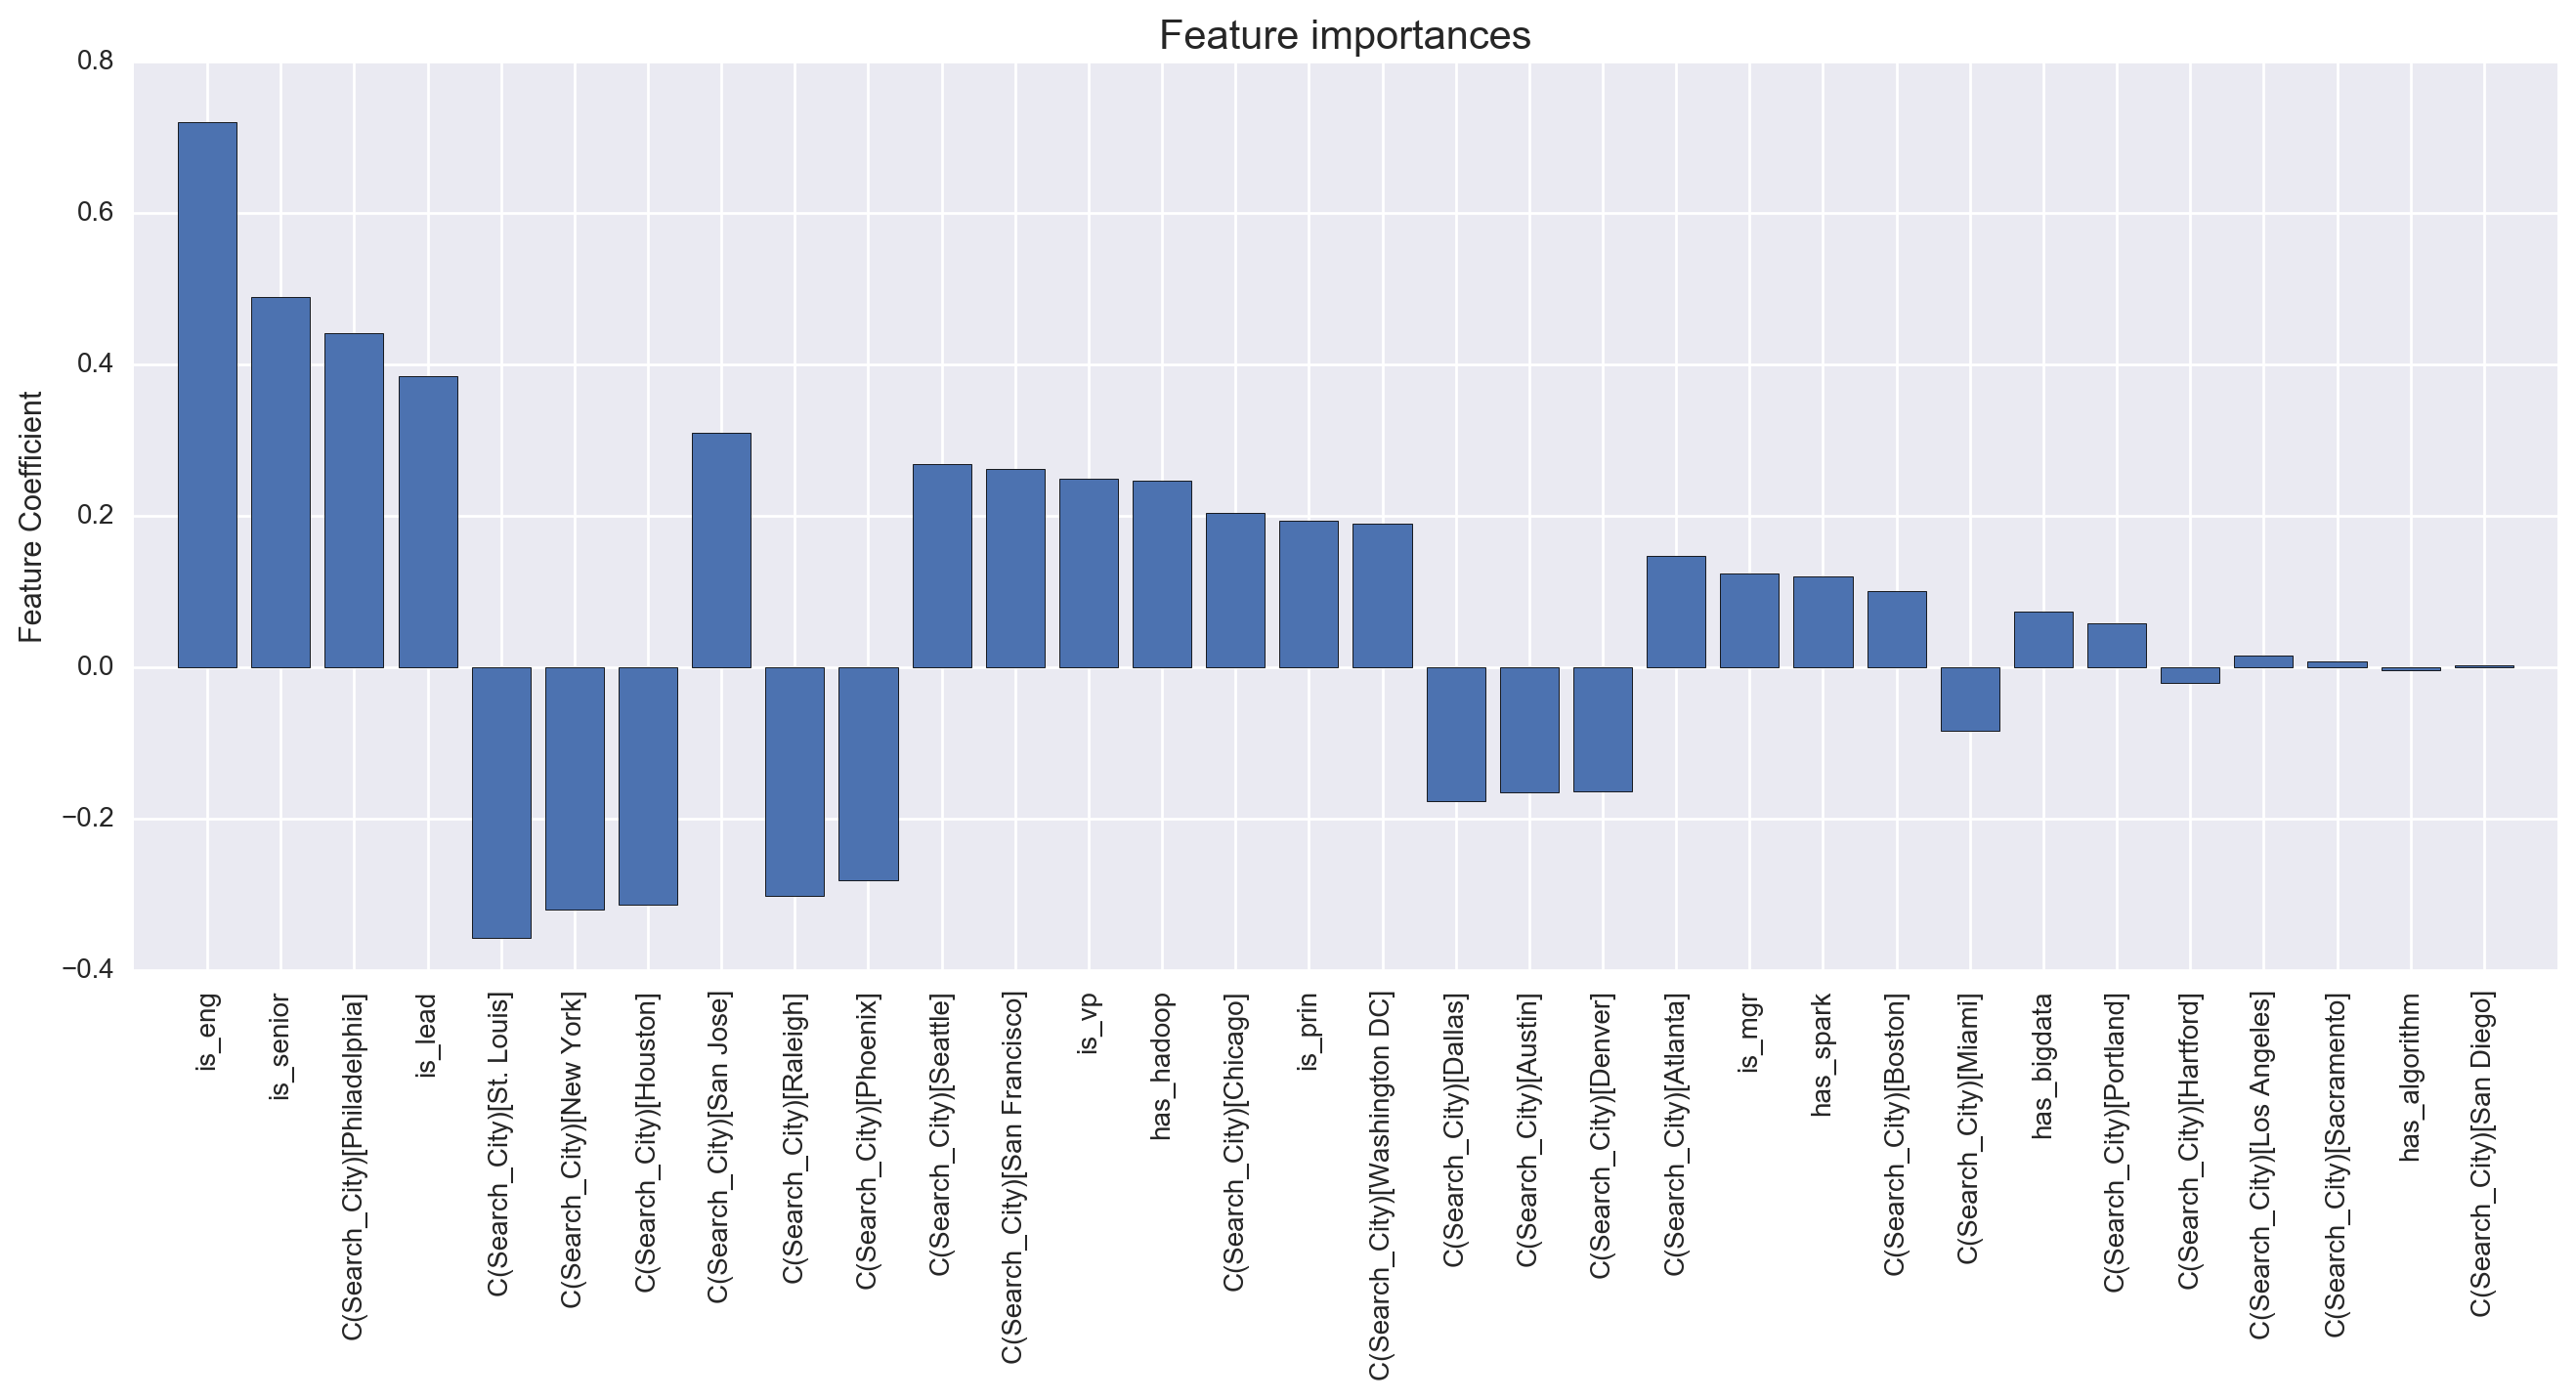

In [70]:
#Plotting importances
importances = lr_ridge2.coef_ # feature importance
indices = np.argsort(np.absolute(importances))# sort importance

# Plot the feature importances
plt.figure(figsize = (16, 6))
plt.title("Feature importances", fontsize = 15)
plt.bar(range(X_has.shape[1]), importances[0][indices][0][::-1], align="center")
plt.ylabel('Feature Coefficient')
plt.xticks(range(X_has.shape[1]), X_has.columns[indices][0][::-1], rotation=90)
plt.xlim([-1, X_has.shape[1]])
plt.show()

From the above we can see that 'hadoop' is a skill most positively associated with higher salaries, with 'spark' and 'bigdata' following. 'Algorithm' seems to have a very small negative effect on the salary.

Let's check model's metrics to assess it's performance:

In [71]:
print 'Accuracy Score', cross_val_score(lr_ridge2,X_has,y,cv=5).mean()
conf_matrix = (confusion_matrix(y, cross_val_predict(lr_ridge2,X_has ,y ,cv=5)))
print 100*'-'
print 'Confusion matrix'
print pd.DataFrame(conf_matrix)
print 100*'-'
print "Classification report"
print classification_report(y,cross_val_predict(lr_ridge2,X_has,y,cv=5))
print 100*'-'
Y_score = lr_ridge2.decision_function(X_has)
print 'AUC:', roc_auc_score(y, Y_score)

Accuracy Score 0.592252776309
----------------------------------------------------------------------------------------------------
Confusion matrix
     0   1
0  107  45
1   80  74
----------------------------------------------------------------------------------------------------
Classification report
             precision    recall  f1-score   support

          0       0.57      0.70      0.63       152
          1       0.62      0.48      0.54       154

avg / total       0.60      0.59      0.59       306

----------------------------------------------------------------------------------------------------
AUC: 0.815469070403


Accuracy, precision and recall  all went down in comparison to previous logistic regression with ridge penalty metrics (without columns referring to skills). This model performs worse than previous one.

#### Take ~100 scraped entries with salaries. Convert them to use with your model and predict the salary - which entries have the highest predicted salaries?

Preparing new file with scraped jobs:

In [115]:
url_template = "http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l={}&start={}"
max_results_per_city = 500

scrap_results = []

for city in cities:
    for start in range(0, max_results_per_city, 10):
        resp = requests.get(url_template.format(city, start))
        html = resp.text
        soup = BeautifulSoup(html, 'html.parser', from_encoding="utf-8")      
        results = soup.find_all('div', attrs={'data-tn-component': 'organicJob'})
        
        for res in results:
            company = get_company_name(res)
            location = get_location(res)
            search_city = city
            job_title = get_job_title(res)
            salary = get_salary(res)
            summary = get_summary(res)
            scrap_results.append([company, location, search_city, job_title, salary, summary])

In [164]:
test_jobs = pd.DataFrame(scrap_results, columns=["Company", "Location", "Search_City", "Job_Title", "Salary", "Summary"])

In [118]:
#Checking how many not null salaries there are:
len(test_jobs[test_jobs.Salary.notnull()])

407

In [166]:
#Dropping the rows with no salary:
test_jobs = test_jobs.dropna()

In [167]:
#Dropping the rows with salary that is not annual:
mask = test_jobs.Salary.str.contains("year")
test_jobs = test_jobs[mask]

In [168]:
#Removing potential duplicates:
test_jobs = test_jobs.drop_duplicates(keep = 'first')
len(test_jobs)

226

In [169]:
#Reindexing:
test_jobs = test_jobs.reset_index(drop=True)

In [170]:
#Cleaning the search_city column
test_jobs["Search_City"] = test_jobs["Search_City"].apply(remove_plus)

In [171]:
# Setting Salary column type as string
test_jobs["Salary"]=test_jobs["Salary"].astype('str')

#Extracting numbers from the string into a new column
test_jobs["Salary_extracted"] =  test_jobs["Salary"].map(lambda x: "".join([d for d in x if d in '1234567890-.']))

In [172]:
test_jobs["Avg_salary"] = test_jobs["Salary_extracted"].apply(avg_salary)

In [173]:
# Dropping uneccessary columns:
test_jobs.drop(['Salary', 'Salary_extracted'], axis=1, inplace=True)

In [163]:
#Saving to csv
test_jobs.to_csv('test_cleaned.csv', encoding='utf-8', index=False)

#### The file is ready, now I will load a dataframe and create additional job title colums, as in previous excercise. As my best model was the one without summary keywords, I'm not going to create additional keyword colums and only use cities and job title keywords as predictors.

In [72]:
test_df = pd.read_csv('test_cleaned.csv', encoding='utf-8')
test_df.head(2)

,Company,Location,Search_City,Job_Title,Summary,Avg_salary
0,State of North Carolina,"Wake County, NC",Raleigh,Medicaid Statistician,"This is a technical position, involving the an...",58617.5
1,North Carolina Office of State Human Resources,"Wake County, NC",Raleigh,Medicaid Statistician,"This is a technical position, involving the an...",58617.5


In [73]:
#Adding binary salary column:
test_df["Binary_Salary"] = test_df.Avg_salary.map(lambda x: 1 if x >= 95000 else 0)

In [74]:
# Convert job title to lowercase
test_df['Job_Title'] = test_df['Job_Title'].apply(lambda x: x.lower())

In [75]:
test_df['is_senior'] = test_df['Job_Title'].str.contains('senior').astype(int)
test_df['is_vp'] = test_df['Job_Title'].str.contains('vp').astype(int) 
test_df['is_mgr'] = test_df['Job_Title'].str.contains('manager').astype(int)
test_df['is_lead'] = test_df['Job_Title'].str.contains('lead').astype(int)
test_df['is_prin'] = test_df['Job_Title'].str.contains('principal').astype(int)
test_df['is_eng'] = test_df['Job_Title'].str.contains('engineer').astype(int)

In [76]:
test_df.head(2)

,Company,Location,Search_City,Job_Title,Summary,Avg_salary,Binary_Salary,is_senior,is_vp,is_mgr,is_lead,is_prin,is_eng
0,State of North Carolina,"Wake County, NC",Raleigh,medicaid statistician,"This is a technical position, involving the an...",58617.5,0,0,0,0,0,0,0
1,North Carolina Office of State Human Resources,"Wake County, NC",Raleigh,medicaid statistician,"This is a technical position, involving the an...",58617.5,0,0,0,0,0,0,0


In [77]:
#Picking 100 random jobs with salaries
test_df_samp = test_df.sample(n=100, replace=False, random_state=7)

In [78]:
test_df_samp.head(2)

,Company,Location,Search_City,Job_Title,Summary,Avg_salary,Binary_Salary,is_senior,is_vp,is_mgr,is_lead,is_prin,is_eng
98,The Forum Group,"New York, NY 10016 (Gramercy area)",New York,marketing research analyst/consumer insights a...,Work with Group Manager/Director on client req...,55000.0,0,0,0,0,0,0,0
46,University of Colorado,"Boulder, CO",Denver,"head, jerry crail johnson earth sciences & map...",Spatial data infrastructure. Experience in dev...,65000.0,0,0,0,0,0,0,0


In [79]:
#Creating predictor matrix:
formula = '~ C(Search_City) + is_senior + is_vp + is_mgr + is_lead + is_prin + is_eng'
X_test = patsy.dmatrix(formula, data=test_df_samp, return_type='dataframe')
y_test = test_df_samp["Binary_Salary"].values

In [80]:
print X_test.shape
print y_test.shape

(100, 28)
(100,)


In [83]:
#Predicting the salary:
yhat = lr_ridge2.predict(X_test)
yhat_pp = lr_ridge2.predict_proba(X_test)

#### Assessing the model's prediction performance:

In [84]:
print "Accuracy", accuracy_score(y_test,yhat)
conf_matrix = confusion_matrix(y_test, yhat)
print 100*'-'
print 'Confusion matrix'
print pd.DataFrame(conf_matrix)
print 100*'-'
print classification_report(y_test, yhat)

Accuracy 0.73
----------------------------------------------------------------------------------------------------
Confusion matrix
    0   1
0  45  15
1  12  28
----------------------------------------------------------------------------------------------------
             precision    recall  f1-score   support

          0       0.79      0.75      0.77        60
          1       0.65      0.70      0.67        40

avg / total       0.73      0.73      0.73       100



## 3. BONUS  - Use Count Vectorizer from scikit-learn to create features from the text summaries.

In [152]:
# Find most common words in summary column
from sklearn.feature_extraction.text import CountVectorizer

cnt_vect = CountVectorizer(binary=True, stop_words='english', max_features=5)
D = cnt_vect.fit(jobs.Summary)
common_words = D.vocabulary_.keys()
print 'Most common words in Summary column:', common_words

Most common words in Summary column: [u'scientist', u'experience', u'analysis', u'team', u'data']


In [153]:
#creating a dataframe with binary values for the 5 most common Summary keywords
df_keywords = cnt_vect.fit_transform(jobs.Summary).todense()
df_keywords = pd.DataFrame(df_keywords, columns=cnt_vect.get_feature_names())
df_keywords.shape

(306, 5)

In [154]:
jobs_keywords =pd.concat([jobs, df_keywords], axis=1)
jobs_keywords.head(2)
jobs_keywords.shape

(306, 22)

In [155]:
jobs_keywords.head(2)

,Company,Location,Search_City,Job_Title,Summary,Avg_salary,Binary_Salary,is_senior,is_vp,is_mgr,...,is_eng,has_hadoop,has_spark,has_algorithm,has_bigdata,analysis,data,experience,scientist,team
0,University of North Carolina,"Chapel Hill, NC 27517",Raleigh,research specialist,prepare posters and other materials for presen...,43854.5,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
1,State of North Carolina,"Wake County, NC",Raleigh,medicaid statistician,"this is a technical position, involving the an...",58617.5,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0


#### Bonus: Use Count Vectorizer from scikit-learn to create features from the text summaries. 
- Examine using count or binary features in the model
- Re-evaluate the logistic regression model using these. Does this improve the model performance? 
- What text features are the most valuable? 

In [156]:
#Checking the count of keywords in each new column:
for item in common_words:
    print item
    print jobs_keywords.ix[:,item].value_counts()
    print "________________________"

scientist
0    225
1     81
Name: scientist, dtype: int64
________________________
experience
0    258
1     48
Name: experience, dtype: int64
________________________
analysis
0    251
1     55
Name: analysis, dtype: int64
________________________
team
0    258
1     48
Name: team, dtype: int64
________________________
data
1    267
0     39
Name: data, dtype: int64
________________________


In [144]:
#creating predictors and target

formula = '~ C(Search_City) + is_senior + is_vp + is_mgr + is_lead + is_prin + is_eng + scientist + experience + analysis + team + data'

X_kwds = patsy.dmatrix(formula, data=jobs_keywords, return_type='dataframe')
y_kwds = jobs_keywords["Binary_Salary"]
print X_kwds.shape
print y_kwds.shape

(306, 33)
(306,)


In [145]:
logreg_kwds = LogisticRegression(C=10**10,solver='lbfgs')
logreg_kwds.fit(X_kwds, y_kwds)

print 'Logreg intercept:', logreg_kwds.intercept_
print 'Logreg coef(s):', logreg_kwds.coef_

Logreg intercept: [-0.11026075]
Logreg coef(s): [[ -0.11026074  -1.32928072  -0.625544    -0.45986529  -2.4030232
   -2.21391861  -2.66980559  -3.19668239  -0.82124739  -1.3858372
   -1.5230297    1.49090818  -1.49904173  -0.23790377  -1.52364467
   -0.25047962  -0.39064941   0.33170184  12.72613807   0.55263765
   -1.82289854   0.25314956   1.07949449  16.55906048   0.92466485
    2.3647311   15.63294523   2.58344905   1.37849516   0.54934205
    0.10833847   0.8365571   -0.27326831]]


In [161]:
#Checking metrics for the ridge_kwds model
print "LOGREG_KWDS METRICS"
print 100*'-'
print 'Accuracy Score', cross_val_score(logreg_kwds,X_kwds,y_kwds,cv=5).mean()
conf_matrix = (confusion_matrix(y_kwds, cross_val_predict(logreg_kwds, X_kwds ,y_kwds ,cv=5)))
print 100*'-'
print 'Confusion matrix'
print pd.DataFrame(conf_matrix)
print 100*'-'
print "Classification report"
print classification_report(y_kwds,cross_val_predict(logreg_kwds,X_kwds,y_kwds,cv=5))
print 100*'-'
Y_score = logreg_kwds.decision_function(X_kwds)
print 'AUC:', roc_auc_score(y_kwds, Y_score)

LOGREG_KWDS METRICS
----------------------------------------------------------------------------------------------------
Accuracy Score 0.547359421823
----------------------------------------------------------------------------------------------------
Confusion matrix
    0   1
0  90  62
1  77  77
----------------------------------------------------------------------------------------------------
Classification report
             precision    recall  f1-score   support

          0       0.54      0.59      0.56       152
          1       0.55      0.50      0.53       154

avg / total       0.55      0.55      0.54       306

----------------------------------------------------------------------------------------------------
AUC: 0.86978810663


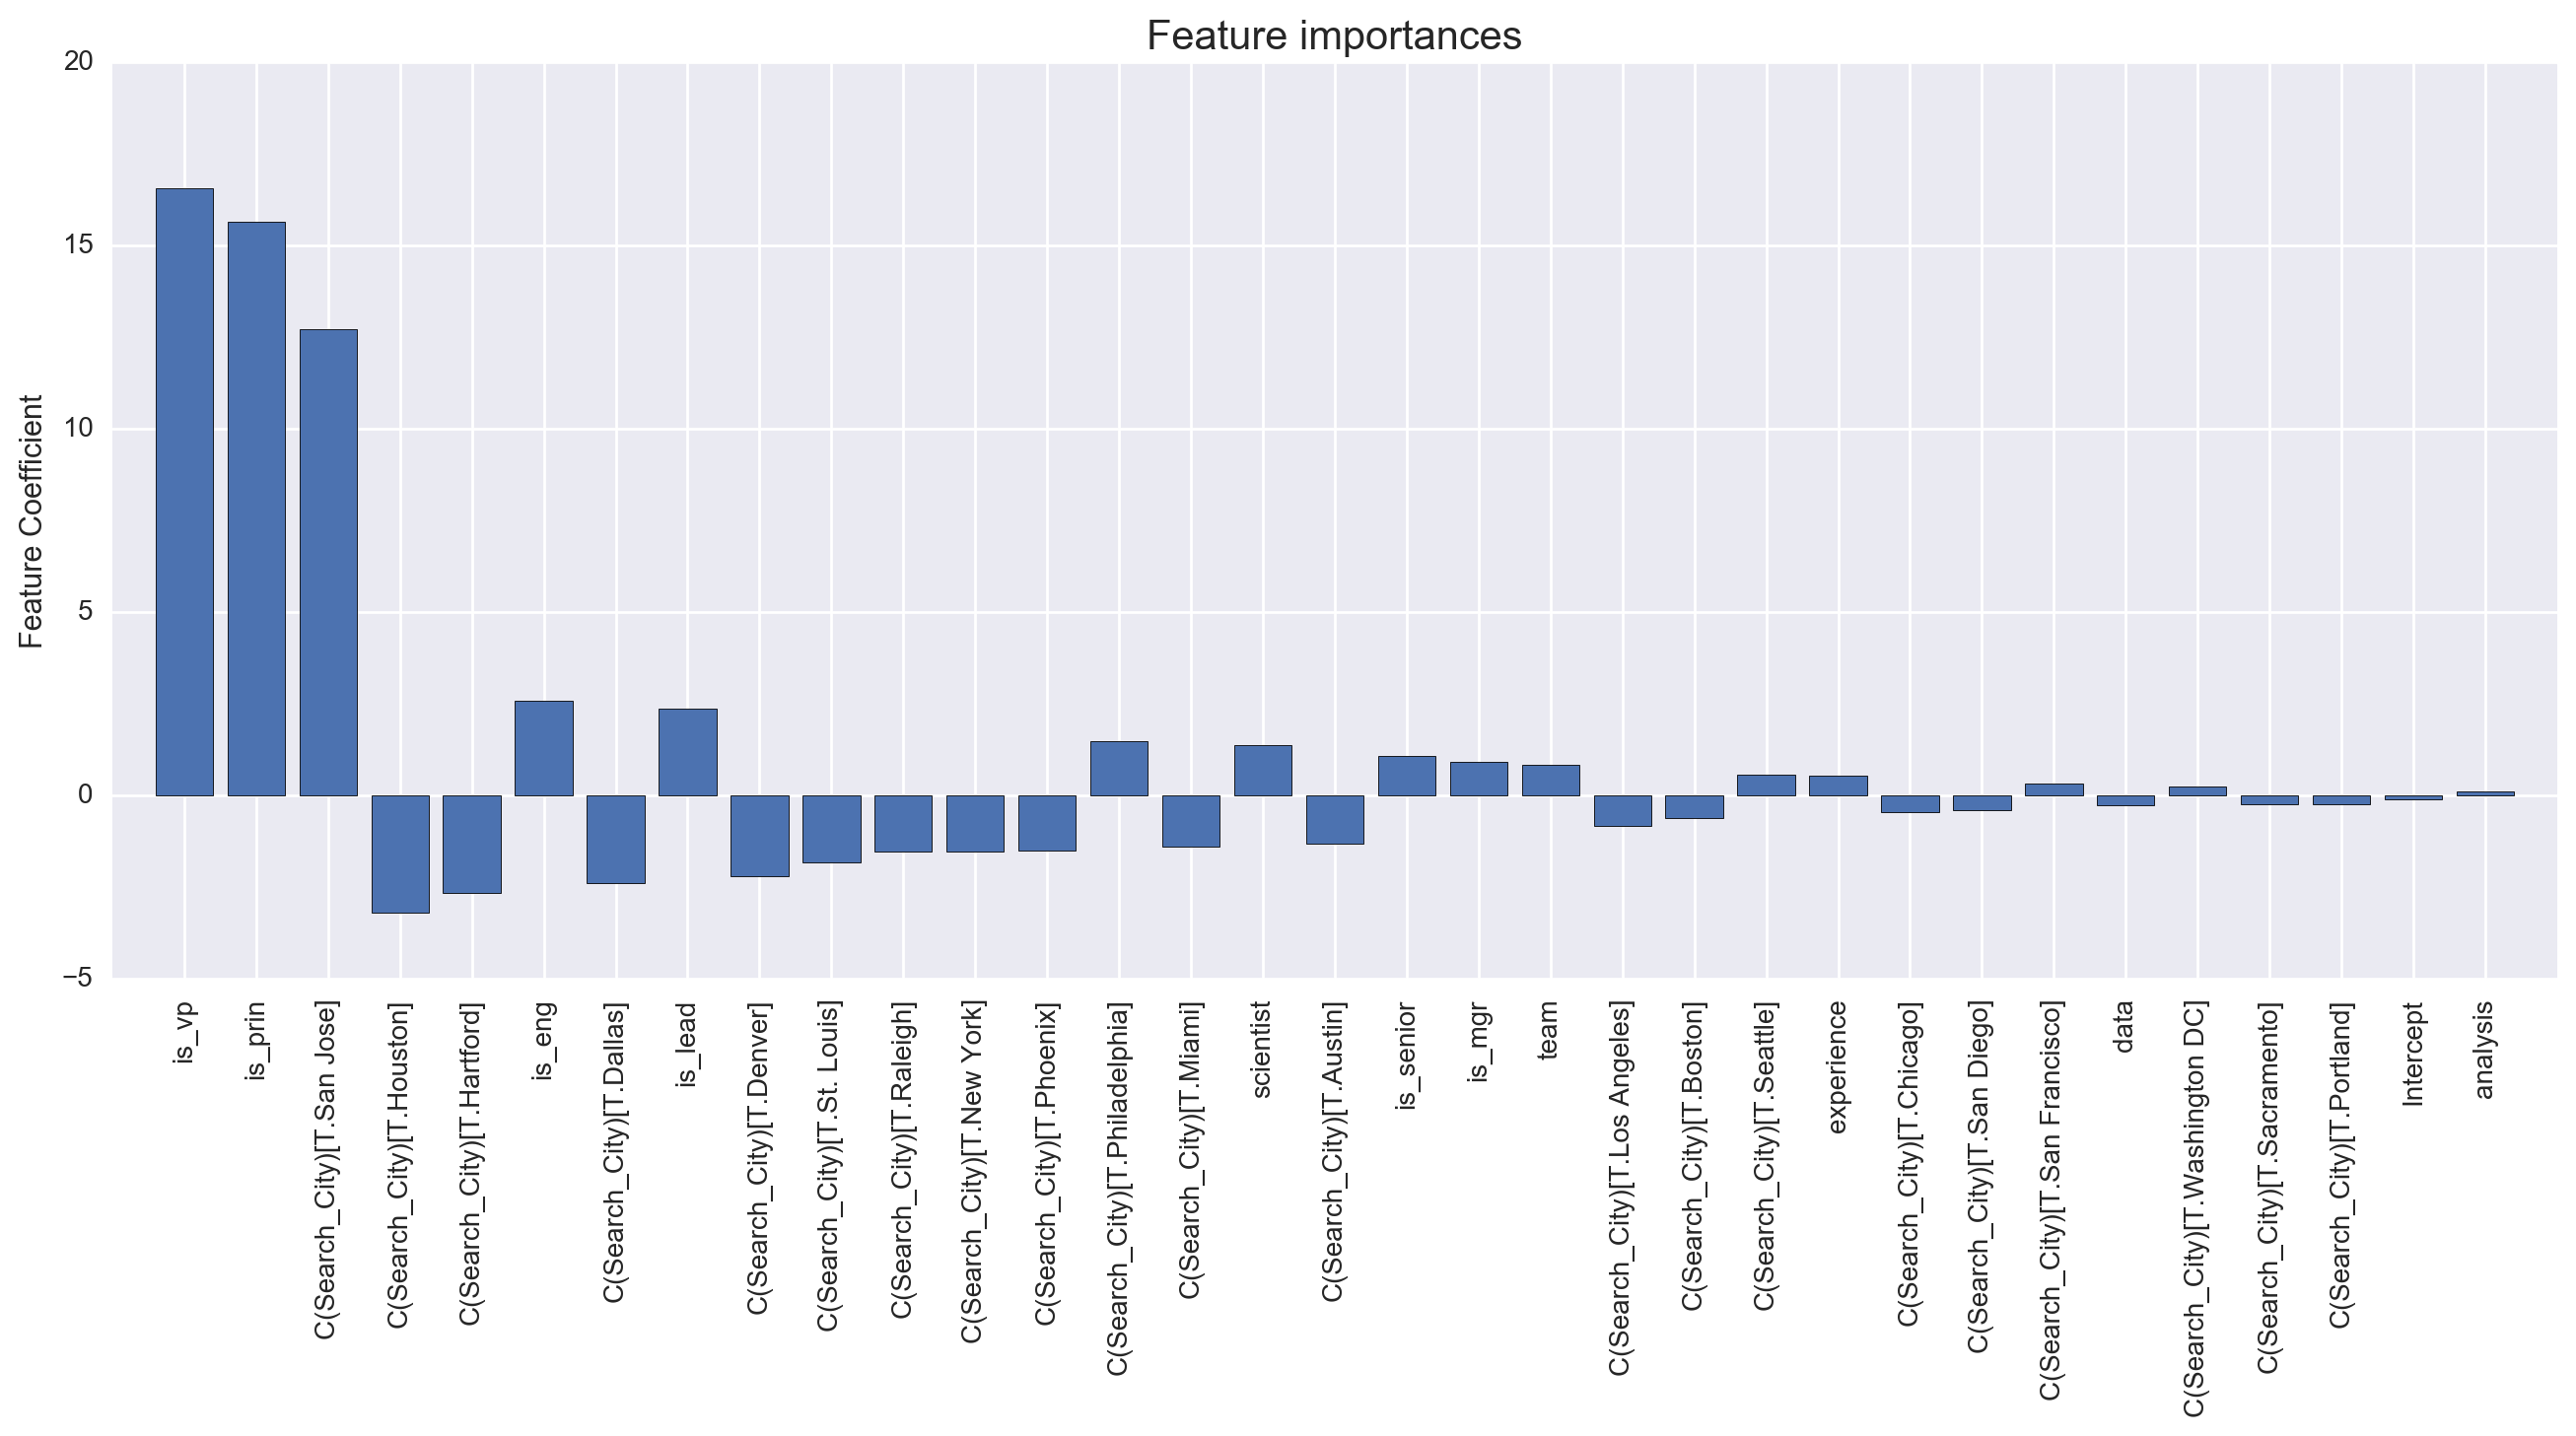

In [146]:
#Plotting coefficients importance

importances = logreg_kwds.coef_ # feature importance
indices = np.argsort(np.absolute(importances))# sort importance

# Plot the feature importances
plt.figure(figsize = (16, 6))
plt.title("Feature importances", fontsize = 15)
plt.bar(range(X_kwds.shape[1]), importances[0][indices][0][::-1], align="center")
plt.ylabel('Feature Coefficient')
plt.xticks(range(X_kwds.shape[1]), X_kwds.columns[indices][0][::-1], rotation=90)
plt.xlim([-1, X_kwds.shape[1]])
plt.show()

All most common summary keywords are associated positvely with HIGH salary though it's not a very pronounced assocaition. Let's look at the regularized model and compare:

#### Re-test L1 and L2 regularization. You can use LogisticRegressionCV to find the optimal reguarlization parameters. 
- Re-test what text features are most valuable.  
- How do L1 and L2 change the coefficients?

In [158]:
# I'm going to use GridSearchCV to find the best parameters
search_parameters = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'penalty': ['l1','l2']}
grid = GridSearchCV(LogisticRegression(), search_parameters, cv=2)
grid.fit(X_kwds, y_kwds)
print grid.best_params_

{'penalty': 'l2', 'C': 0.1}


GridSearch suggests L2 penalty as the optimal solution. Let's implement it:

In [159]:
ridge_kwds = LogisticRegression(penalty='l2', C=0.1)
ridge_kwds.fit(X_kwds, y_kwds)

print 'Ridge2 intercept:', ridge_kwds.intercept_
print 'Ridge2 coef(s):', ridge_kwds.coef_

Ridge2 intercept: [-0.14062801]
Ridge2 coef(s): [[-0.14062801 -0.12505149  0.09332532  0.12449678 -0.17742957 -0.13999148
  -0.02055054 -0.31427583 -0.01632245 -0.0833963  -0.3103308   0.39705689
  -0.2496499   0.03199796 -0.25648119  0.00834804  0.02773226  0.26232014
   0.29751182  0.26166463 -0.32412586  0.19448451  0.40955223  0.21521845
   0.12856787  0.31171457  0.14444778  0.76836229  0.64115665  0.26596606
  -0.22589467  0.53142256 -0.11005107]]


In [162]:
#Checking metrics for the ridge_kwds model
print "RIDGE_KWDS METRICS"
print 100*'-'
print 'Accuracy Score', cross_val_score(ridge_kwds,X_kwds,y_kwds,cv=5).mean()
conf_matrix = (confusion_matrix(y_kwds, cross_val_predict(ridge_kwds, X_kwds ,y_kwds ,cv=5)))
print 100*'-'
print 'Confusion matrix'
print pd.DataFrame(conf_matrix)
print 100*'-'
print "Classification report"
print classification_report(y_kwds,cross_val_predict(ridge_kwds,X_kwds,y_kwds,cv=5))
print 100*'-'
Y_score = ridge_kwds.decision_function(X_kwds)
print 'AUC:', roc_auc_score(y_kwds, Y_score)

RIDGE_KWDS METRICS
----------------------------------------------------------------------------------------------------
Accuracy Score 0.683432046536
----------------------------------------------------------------------------------------------------
Confusion matrix
     0    1
0  105   47
1   50  104
----------------------------------------------------------------------------------------------------
Classification report
             precision    recall  f1-score   support

          0       0.68      0.69      0.68       152
          1       0.69      0.68      0.68       154

avg / total       0.68      0.68      0.68       306

----------------------------------------------------------------------------------------------------
AUC: 0.840738209159


The ridge returns better metrics that ordinary logistic regression.

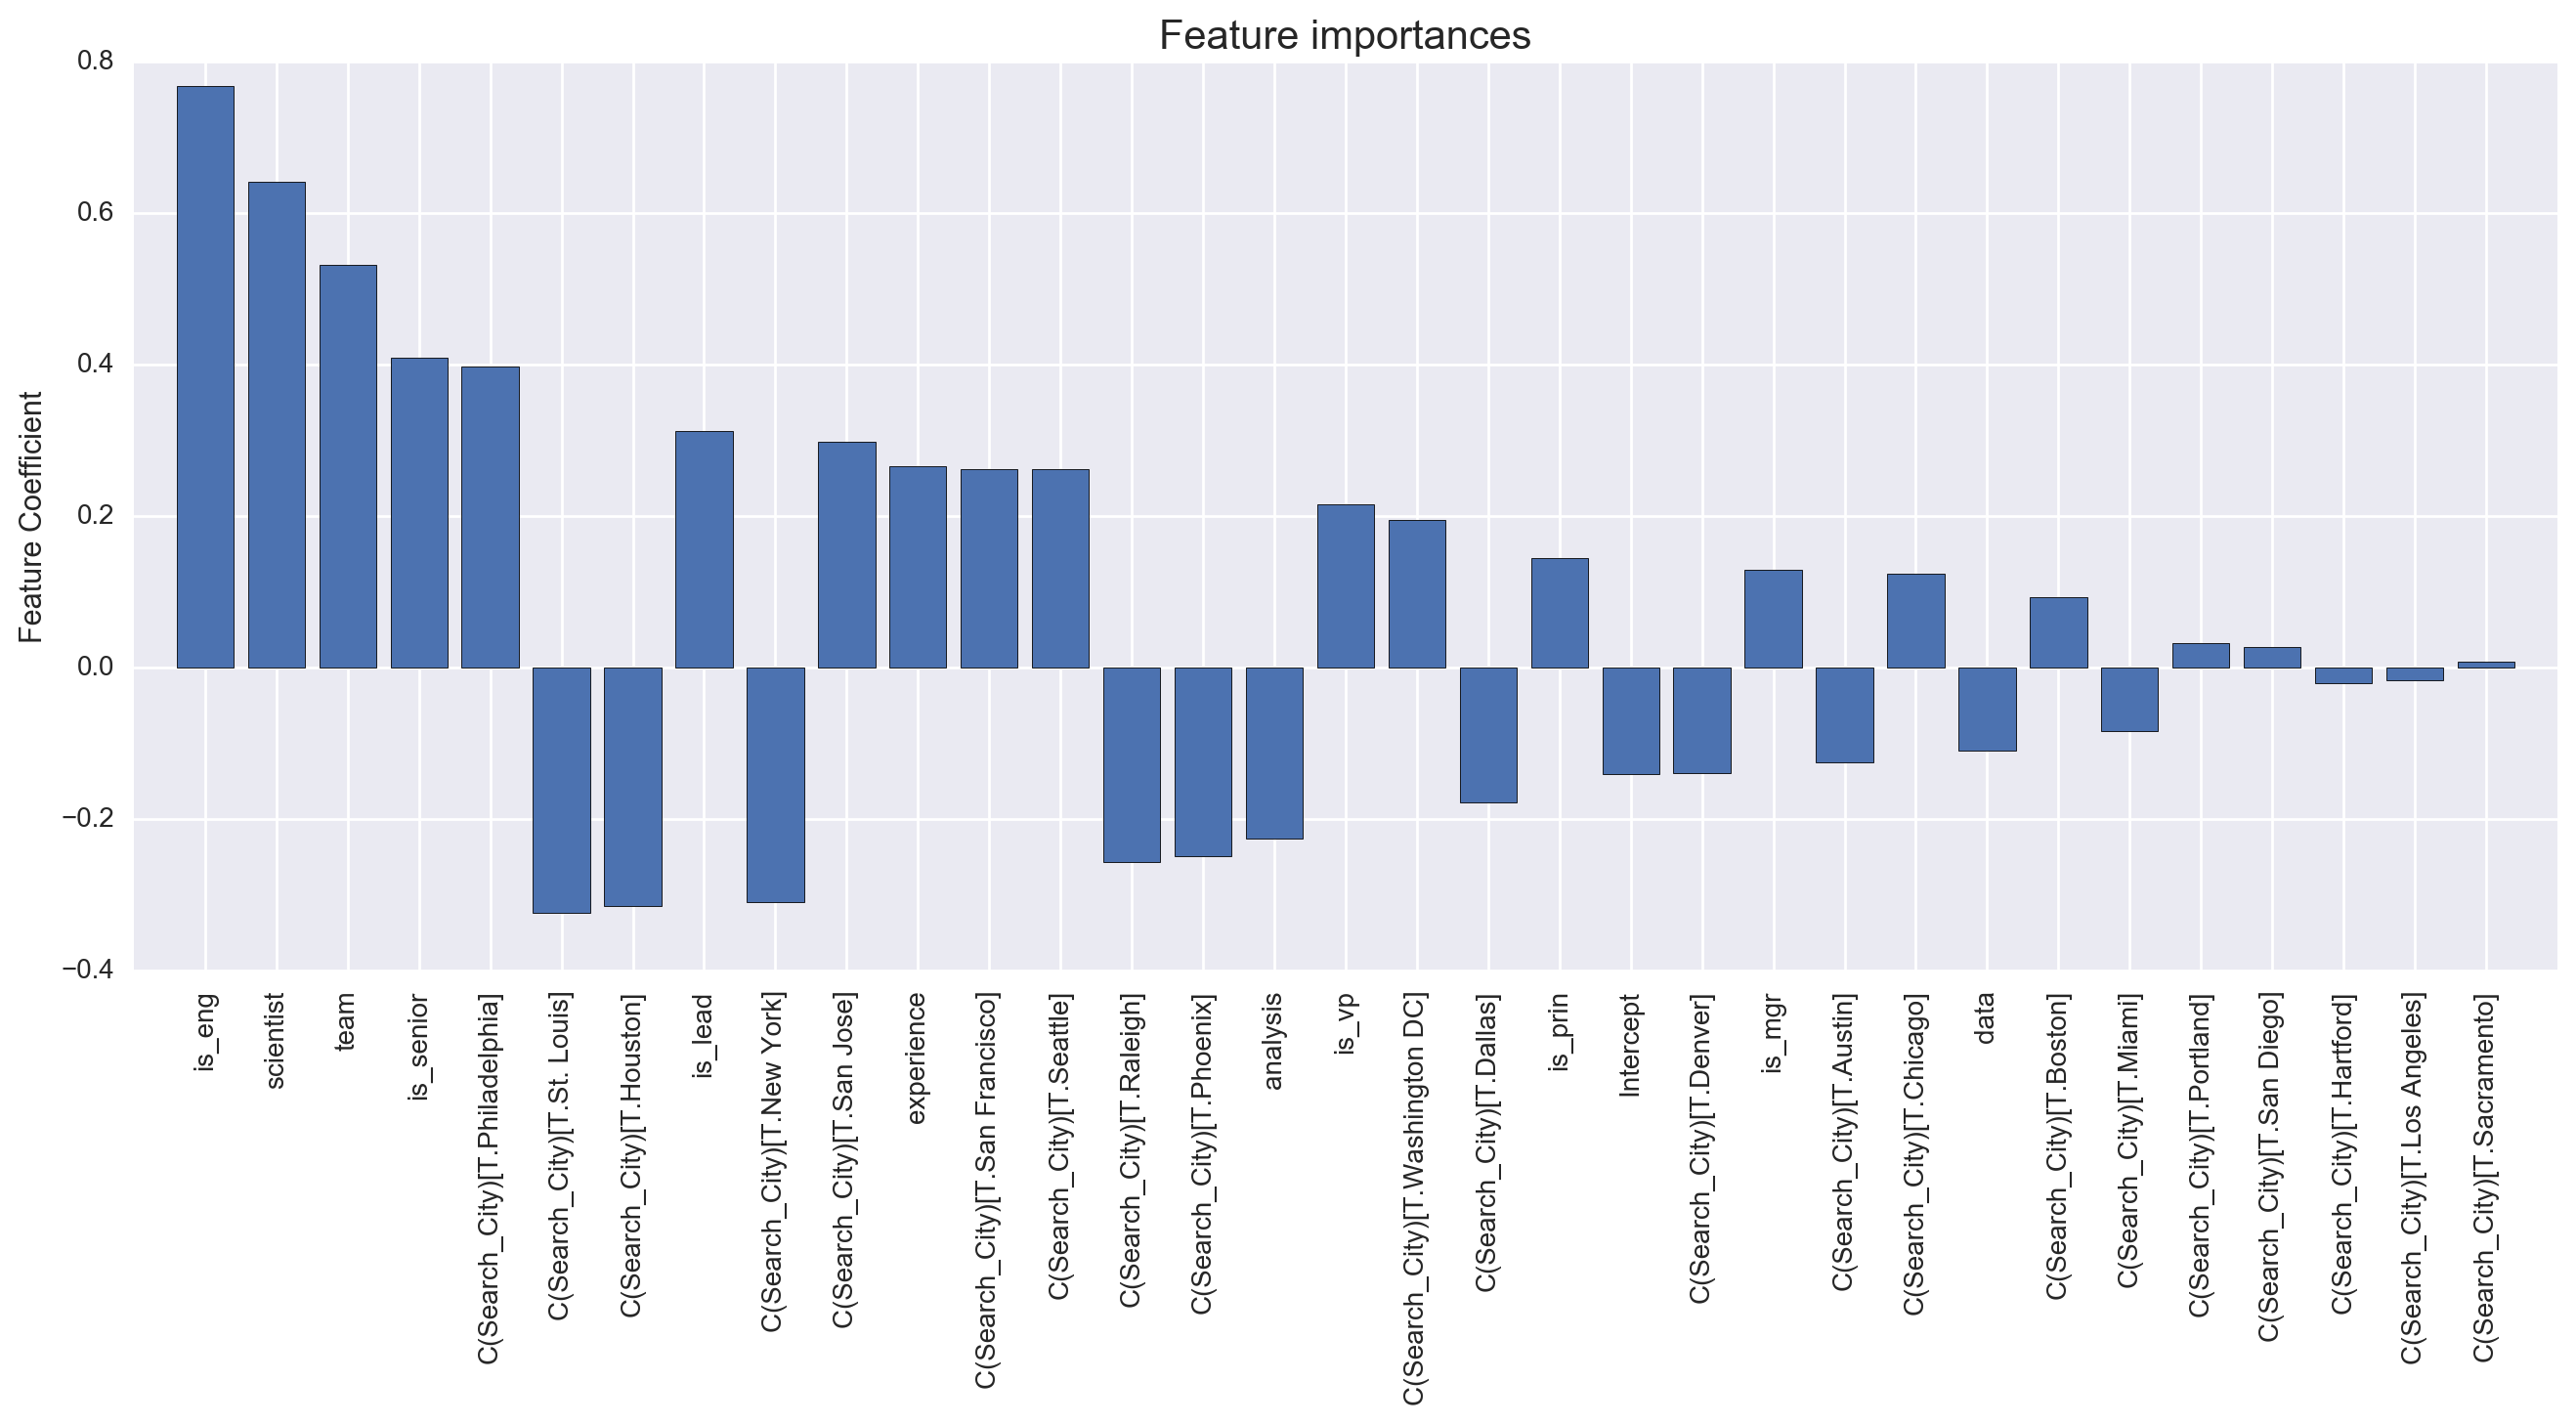

In [163]:
#Plotting coefficients importance

importances = ridge_kwds.coef_ # feature importance
indices = np.argsort(np.absolute(importances))# sort importance

# Plot the feature importances
plt.figure(figsize = (16, 6))
plt.title("Feature importances", fontsize = 15)
plt.bar(range(X_kwds.shape[1]), importances[0][indices][0][::-1], align="center")
plt.ylabel('Feature Coefficient')
plt.xticks(range(X_kwds.shape[1]), X_kwds.columns[indices][0][::-1], rotation=90)
plt.xlim([-1, X_kwds.shape[1]])
plt.show()

In the above model we can see that coefficients have been shrinked in comparison with the previous one and that somewhat different features are positively and negatively associated with the HIGH salaries. Namely, features having the most prononunced assosciation with HIGH salaries are 'engineer' (title keyword), 'scientist' (summary keyword), 'team' (summary keyword), 'senior'  (title keyword) and 'Philadephia' (location).

## 4. REPORT

#### Abstract

The goal of the project was to investigate relationship between certain features present in online job adverts and the salary levels of data scientists. Analysis and modeling has been performed on data concerning data scientists roles in some large cities and ‘tech capitals’ in USA  advertised on a job portal Indeed.com.

The investigation identified some key features present in the job adverts that can be associated with higher salaries, such as location or certain keywords present in job title. It has been observed that jobs in certain cities such as San Jose and Philadelphia tend to have salaries above median as have the jobs containing ‘principal’ or ‘engineer’  in their title. 

#### Introduction

Since data scientist was announced the “sexiest job on the planet” the demand for professionals with data science background is on the rise. As a contracting company we need to keep close eye on the job market to make sure we offer competitive salaries to our contractors while offering the best value to the  clients at the same time. Being able to predicting salaries levels would be a great asset to the company.

#### Methods

10222 job adverts in 23 US locations has been retrieved from Indeed.com. After initial data cleaning and assessment 306 observations containing annual salary has been deemed complete and fit for purpose of modeling. The characteristics potentially influencing salary levels were as follows: location (city), job title, summary keywords. 

Extracted salaries were divided in two levels:

* LOW salaries (below median, ie USD95,000)
* HIGH salaries (above median, ie USD95,000)

With help of data analysis and modeling we attempted to detect association between thee above mentioned characteristics and salary levels.

#### Results
The pay range for data scientists is very wide, starting from $24,000 at low end and ending at $250,000 at the high end of the scale.
Having run multiple models incorporating various combinations of influencing features, we can conclude that locations associated with salaries are San Jose, Philadephia, Seattle and San Francisco. 

When it comes to job titles associated with high salaries, all those indicating higher position in professional hierarchy are indeed deemed important by our model, with ‘senior’, ‘lead’, ‘vp’ and ‘principal’ in the lead. 
One more characteristic closely related to the high salary is summary keywords. For our analysis we have chosen keywords that may indicate skills required from candidate for a job role. Out of these, ‘hadoop’, ‘spark’ and ‘big data’ seem to have strongest associations with high salaries.
